In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [3]:
train = True

In [4]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [5]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [10]:
epoch = 200

In [11]:
root = 'src/data/dyn_pid_controller_1d/exploratory_penality'

In [12]:
def train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size):
    if train:
        spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=activation), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = replay_size, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
    trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
    evaluator_ddpg = env()
    history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory[0, :])

    w = trained_ac.pi.state_dict()

    saved_weights = {}
    for key, value in w.items():
        saved_weights[key] = value.detach().numpy().tolist()

    with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
        json.dump(saved_weights, json_file, indent=1)
    
    print("MSE :", loss_ddpg)

    log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
    axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
    axs[0].set_ylabel('AvergeEpRet')
    axs[0].legend()
    axs[0].set_xlabel('Epoch')

    axs[1].plot(log['LossPi'])
    axs[1].set_ylabel('Actor loss')
    axs[1].set_xlabel('Epoch')

    axs[2].plot(log['LossQ'])
    axs[2].set_ylabel('Critic loss')
    axs[2].set_xlabel('Epoch')

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 10))

    axs[0].plot(t, history_ddpg, label='x_ddpg')
    axs[0].plot(t, test_trajectory[0, :], label='target')
    axs[0].set_ylabel('Ball position [m]')
    axs[0].set_ylim([-MAX_X, MAX_X])
    axs[0].legend()

    axs[1].plot(t, error_ddpg, label='x')
    axs[1].set_ylabel('Ball error [m]')
    axs[1].set_ylim([-MAX_X, MAX_X])
    axs[1].legend()

    axs[2].plot(t, angle_ddpg, label='angle_ddpg')
    axs[2].plot(t, u_ddpg, label='u_ddpg')
    axs[2].set_ylabel('Motor x angle [deg]')
    axs[2].legend()
    
    axs[3].plot(t, kp, label='kp')
    axs[3].plot(t, kd, label='kd')
    axs[3].plot(t, ki, label='ki')
    axs[3].set_ylabel('PID weights')
    axs[3].legend()

    plt.show()

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50]_relu_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            50
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3db2a72d68>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50]_relu_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50]_relu_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
     

/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |              89 |
|          StdEpRet |            12.9 |
|          MaxEpRet |             102 |
|          MinEpRet |            76.1 |
|  AverageTestEpRet |             110 |
|      StdTestEpRet |            44.4 |
|      MaxTestEpRet |             302 |
|      MinTestEpRet |            90.3 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.1e+03 |
|      AverageQVals |           0.574 |
|          StdQVals |           0.214 |
|          MaxQVals |            10.7 |
|          MinQVals |           -1.42 |
|            LossPi |          -0.678 |
|             LossQ |          0.0944 |
|              Time |            5.66 |
---------------------------------------
---------------------------------------
|             Epoch |               2 |
|      AverageEpRet |             129 |
|          StdEpRet |            88.4 |


---------------------------------------
|             Epoch |              11 |
|      AverageEpRet |            85.3 |
|          StdEpRet |            9.46 |
|          MaxEpRet |            98.6 |
|          MinEpRet |              78 |
|  AverageTestEpRet |             280 |
|      StdTestEpRet |            22.9 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             247 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.21e+04 |
|      AverageQVals |            18.6 |
|          StdQVals |            4.64 |
|          MaxQVals |            27.8 |
|          MinQVals |           -18.5 |
|            LossPi |           -18.7 |
|             LossQ |          0.0422 |
|              Time |             110 |
---------------------------------------
---------------------------------------
|             Epoch |              12 |
|      AverageEpRet |             147 |
|          StdEpRet |            83.6 |


---------------------------------------
|             Epoch |              21 |
|      AverageEpRet |             187 |
|          StdEpRet |            93.7 |
|          MaxEpRet |             281 |
|          MinEpRet |            93.3 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            15.2 |
|      MaxTestEpRet |             330 |
|      MinTestEpRet |             280 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.31e+04 |
|      AverageQVals |            33.2 |
|          StdQVals |            13.8 |
|          MaxQVals |            50.7 |
|          MinQVals |           -17.6 |
|            LossPi |           -33.4 |
|             LossQ |           0.105 |
|              Time |             262 |
---------------------------------------
---------------------------------------
|             Epoch |              22 |
|      AverageEpRet |             275 |
|          StdEpRet |            6.88 |


---------------------------------------
|             Epoch |              31 |
|      AverageEpRet |             267 |
|          StdEpRet |            20.2 |
|          MaxEpRet |             295 |
|          MinEpRet |             252 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            33.9 |
|      MaxTestEpRet |             337 |
|      MinTestEpRet |             222 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.41e+04 |
|      AverageQVals |            50.2 |
|          StdQVals |            15.7 |
|          MaxQVals |            67.2 |
|          MinQVals |           -29.2 |
|            LossPi |           -50.5 |
|             LossQ |           0.113 |
|              Time |             397 |
---------------------------------------
---------------------------------------
|             Epoch |              32 |
|      AverageEpRet |             259 |
|          StdEpRet |            59.7 |


---------------------------------------
|             Epoch |              41 |
|      AverageEpRet |             281 |
|          StdEpRet |            34.6 |
|          MaxEpRet |             315 |
|          MinEpRet |             246 |
|  AverageTestEpRet |             285 |
|      StdTestEpRet |            47.9 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             185 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.51e+04 |
|      AverageQVals |              60 |
|          StdQVals |            15.7 |
|          MaxQVals |            75.7 |
|          MinQVals |           -27.1 |
|            LossPi |           -60.1 |
|             LossQ |           0.114 |
|              Time |             515 |
---------------------------------------
---------------------------------------
|             Epoch |              42 |
|      AverageEpRet |             211 |
|          StdEpRet |            26.7 |


---------------------------------------
|             Epoch |              51 |
|      AverageEpRet |             270 |
|          StdEpRet |            32.2 |
|          MaxEpRet |             302 |
|          MinEpRet |             226 |
|  AverageTestEpRet |             279 |
|      StdTestEpRet |            33.7 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             234 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.61e+04 |
|      AverageQVals |            65.7 |
|          StdQVals |            15.7 |
|          MaxQVals |            80.4 |
|          MinQVals |             -23 |
|            LossPi |           -65.9 |
|             LossQ |           0.191 |
|              Time |             640 |
---------------------------------------
---------------------------------------
|             Epoch |              52 |
|      AverageEpRet |             245 |
|          StdEpRet |            44.3 |


---------------------------------------
|             Epoch |              61 |
|      AverageEpRet |             267 |
|          StdEpRet |            14.7 |
|          MaxEpRet |             281 |
|          MinEpRet |             252 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            27.1 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             244 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.71e+04 |
|      AverageQVals |            70.3 |
|          StdQVals |            14.8 |
|          MaxQVals |            82.9 |
|          MinQVals |             -17 |
|            LossPi |           -70.5 |
|             LossQ |           0.172 |
|              Time |             756 |
---------------------------------------
---------------------------------------
|             Epoch |              62 |
|      AverageEpRet |             254 |
|          StdEpRet |            10.4 |


---------------------------------------
|             Epoch |              71 |
|      AverageEpRet |             288 |
|          StdEpRet |            5.48 |
|          MaxEpRet |             293 |
|          MinEpRet |             280 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            23.8 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.81e+04 |
|      AverageQVals |            73.5 |
|          StdQVals |            13.9 |
|          MaxQVals |            84.8 |
|          MinQVals |           -17.6 |
|            LossPi |           -73.6 |
|             LossQ |           0.126 |
|              Time |             875 |
---------------------------------------
---------------------------------------
|             Epoch |              72 |
|      AverageEpRet |             252 |
|          StdEpRet |            6.27 |


---------------------------------------
|             Epoch |              81 |
|      AverageEpRet |             263 |
|          StdEpRet |            4.49 |
|          MaxEpRet |             267 |
|          MinEpRet |             258 |
|  AverageTestEpRet |             296 |
|      StdTestEpRet |            29.6 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             236 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.91e+04 |
|      AverageQVals |            75.7 |
|          StdQVals |              14 |
|          MaxQVals |            85.1 |
|          MinQVals |           -18.3 |
|            LossPi |           -75.8 |
|             LossQ |           0.138 |
|              Time |             975 |
---------------------------------------
---------------------------------------
|             Epoch |              82 |
|      AverageEpRet |             278 |
|          StdEpRet |            48.5 |


---------------------------------------
|             Epoch |              91 |
|      AverageEpRet |             291 |
|          StdEpRet |            23.6 |
|          MaxEpRet |             317 |
|          MinEpRet |             260 |
|  AverageTestEpRet |             297 |
|      StdTestEpRet |              40 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             225 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |           1e+05 |
|      AverageQVals |            78.5 |
|          StdQVals |            10.9 |
|          MaxQVals |            87.5 |
|          MinQVals |           -14.8 |
|            LossPi |           -78.6 |
|             LossQ |           0.112 |
|              Time |        1.05e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              92 |
|      AverageEpRet |             279 |
|          StdEpRet |            19.5 |


---------------------------------------
|             Epoch |             101 |
|      AverageEpRet |             278 |
|          StdEpRet |            7.88 |
|          MaxEpRet |             286 |
|          MinEpRet |             270 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            27.4 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             235 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.11e+05 |
|      AverageQVals |            80.2 |
|          StdQVals |            8.99 |
|          MaxQVals |            88.9 |
|          MinQVals |           -2.95 |
|            LossPi |           -80.3 |
|             LossQ |           0.107 |
|              Time |        1.13e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             102 |
|      AverageEpRet |             283 |
|          StdEpRet |            16.6 |


---------------------------------------
|             Epoch |             111 |
|      AverageEpRet |             309 |
|          StdEpRet |            17.6 |
|          MaxEpRet |             333 |
|          MinEpRet |             293 |
|  AverageTestEpRet |             296 |
|      StdTestEpRet |            30.7 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             237 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.22e+05 |
|      AverageQVals |            80.7 |
|          StdQVals |            9.12 |
|          MaxQVals |            89.7 |
|          MinQVals |            2.35 |
|            LossPi |           -80.7 |
|             LossQ |           0.114 |
|              Time |         1.2e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             112 |
|      AverageEpRet |             292 |
|          StdEpRet |            16.2 |


---------------------------------------
|             Epoch |             121 |
|      AverageEpRet |             302 |
|          StdEpRet |            22.7 |
|          MaxEpRet |             325 |
|          MinEpRet |             279 |
|  AverageTestEpRet |             291 |
|      StdTestEpRet |            31.9 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             227 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.33e+05 |
|      AverageQVals |            81.1 |
|          StdQVals |            8.69 |
|          MaxQVals |            90.8 |
|          MinQVals |            2.88 |
|            LossPi |           -81.1 |
|             LossQ |           0.113 |
|              Time |        1.29e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             122 |
|      AverageEpRet |             263 |
|          StdEpRet |            18.7 |


---------------------------------------
|             Epoch |             131 |
|      AverageEpRet |             274 |
|          StdEpRet |            35.3 |
|          MaxEpRet |             321 |
|          MinEpRet |             236 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            33.1 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             232 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.44e+05 |
|      AverageQVals |            81.1 |
|          StdQVals |            8.85 |
|          MaxQVals |            91.2 |
|          MinQVals |            5.18 |
|            LossPi |           -81.1 |
|             LossQ |           0.142 |
|              Time |        1.39e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             132 |
|      AverageEpRet |             299 |
|          StdEpRet |            36.4 |


---------------------------------------
|             Epoch |             141 |
|      AverageEpRet |             283 |
|          StdEpRet |            10.4 |
|          MaxEpRet |             293 |
|          MinEpRet |             272 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |            22.8 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.55e+05 |
|      AverageQVals |            81.3 |
|          StdQVals |            8.65 |
|          MaxQVals |            90.6 |
|          MinQVals |            12.5 |
|            LossPi |           -81.4 |
|             LossQ |           0.133 |
|              Time |         1.5e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             142 |
|      AverageEpRet |             281 |
|          StdEpRet |            3.85 |


---------------------------------------
|             Epoch |             151 |
|      AverageEpRet |             277 |
|          StdEpRet |            19.4 |
|          MaxEpRet |             297 |
|          MinEpRet |             251 |
|  AverageTestEpRet |             291 |
|      StdTestEpRet |            32.2 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             227 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.66e+05 |
|      AverageQVals |            81.8 |
|          StdQVals |            8.56 |
|          MaxQVals |            89.9 |
|          MinQVals |            7.47 |
|            LossPi |           -81.9 |
|             LossQ |           0.157 |
|              Time |        1.62e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             152 |
|      AverageEpRet |             287 |
|          StdEpRet |            31.9 |


---------------------------------------
|             Epoch |             161 |
|      AverageEpRet |            99.7 |
|          StdEpRet |            28.3 |
|          MaxEpRet |             128 |
|          MinEpRet |            71.5 |
|  AverageTestEpRet |             207 |
|      StdTestEpRet |            72.1 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             101 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.77e+05 |
|      AverageQVals |            81.8 |
|          StdQVals |            8.48 |
|          MaxQVals |              89 |
|          MinQVals |            9.26 |
|            LossPi |           -81.8 |
|             LossQ |           0.137 |
|              Time |        1.76e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             162 |
|      AverageEpRet |             186 |
|          StdEpRet |             102 |


---------------------------------------
|             Epoch |             171 |
|      AverageEpRet |             263 |
|          StdEpRet |            11.9 |
|          MaxEpRet |             274 |
|          MinEpRet |             246 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            24.5 |
|      MaxTestEpRet |             337 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.88e+05 |
|      AverageQVals |            82.4 |
|          StdQVals |            9.81 |
|          MaxQVals |            93.3 |
|          MinQVals |            12.9 |
|            LossPi |           -82.5 |
|             LossQ |           0.162 |
|              Time |        1.86e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             172 |
|      AverageEpRet |             286 |
|          StdEpRet |            4.79 |


---------------------------------------
|             Epoch |             181 |
|      AverageEpRet |             191 |
|          StdEpRet |            63.9 |
|          MaxEpRet |             255 |
|          MinEpRet |             127 |
|  AverageTestEpRet |             253 |
|      StdTestEpRet |            96.1 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |              49 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.99e+05 |
|      AverageQVals |            82.2 |
|          StdQVals |            8.54 |
|          MaxQVals |            93.3 |
|          MinQVals |              15 |
|            LossPi |           -82.3 |
|             LossQ |           0.119 |
|              Time |        1.95e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             182 |
|      AverageEpRet |             289 |
|          StdEpRet |            28.6 |


---------------------------------------
|             Epoch |             191 |
|      AverageEpRet |             279 |
|          StdEpRet |            3.02 |
|          MaxEpRet |             283 |
|          MinEpRet |             276 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            23.3 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         2.1e+05 |
|      AverageQVals |            81.3 |
|          StdQVals |            8.38 |
|          MaxQVals |            90.7 |
|          MinQVals |           -1.64 |
|            LossPi |           -81.4 |
|             LossQ |          0.0801 |
|              Time |        2.02e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             192 |
|      AverageEpRet |             300 |
|          StdEpRet |            41.8 |


{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.01595547], dtype=float32), array([-0.02559491], dtype=float32), array([0.00293015], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.20217597050053157


<IPython.core.display.Javascript object>


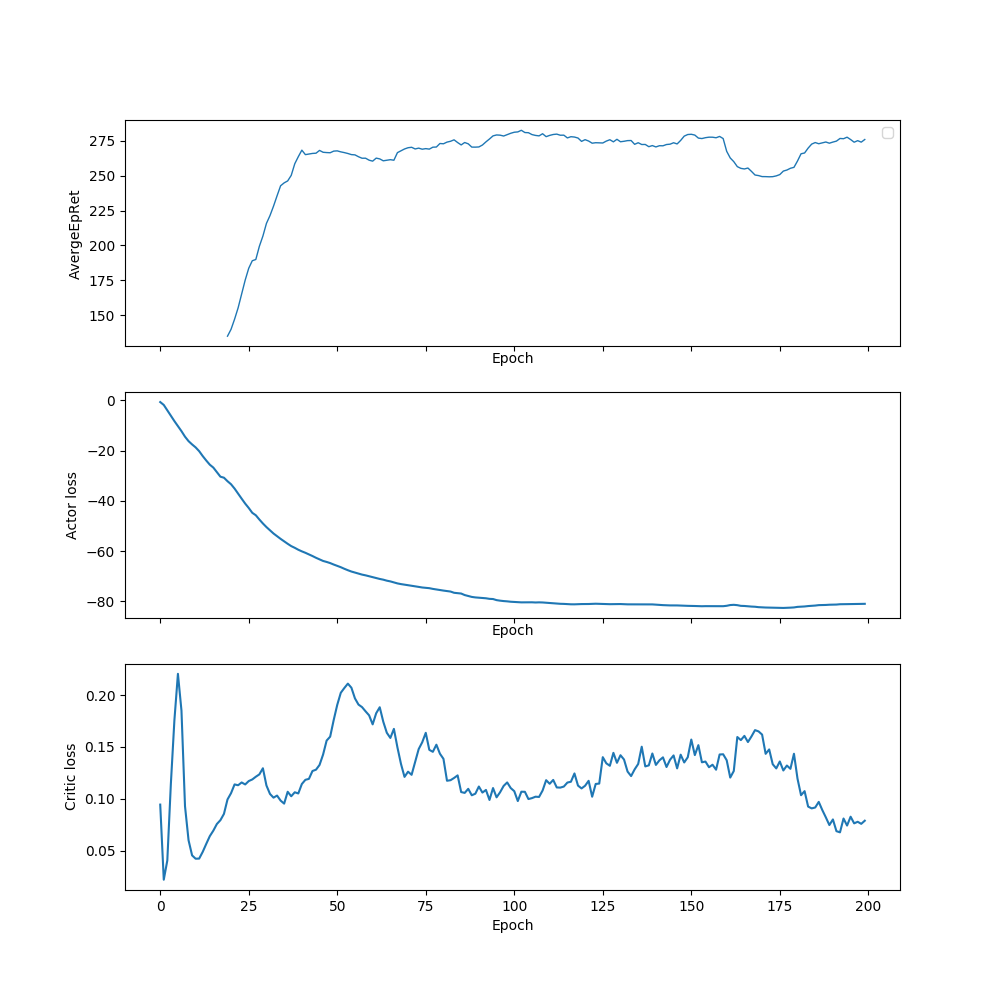

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


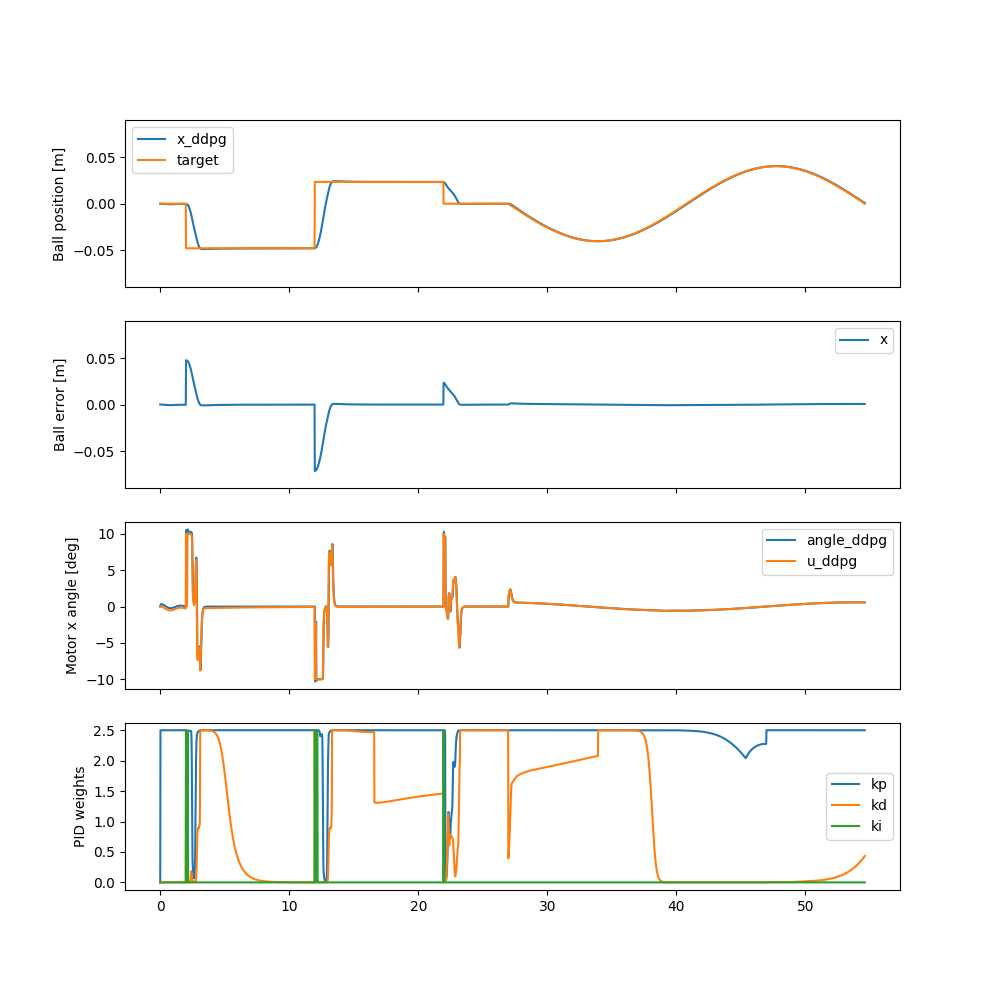

In [14]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[50]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100]_relu_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3dc8a4c780>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100]_relu_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100]_relu_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
 

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            73.5 |
|          StdEpRet |            13.5 |
|          MaxEpRet |            86.9 |
|          MinEpRet |            55.1 |
|  AverageTestEpRet |             255 |
|      StdTestEpRet |            64.3 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             139 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            15.8 |
|          StdQVals |            6.42 |
|          MaxQVals |            29.1 |
|          MinQVals |           -15.3 |
|            LossPi |             -16 |
|             LossQ |           0.129 |
|              Time |            53.5 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |              75 |
|          StdEpRet |            10.7 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             277 |
|          StdEpRet |            8.45 |
|          MaxEpRet |             289 |
|          MinEpRet |             270 |
|  AverageTestEpRet |             288 |
|      StdTestEpRet |            26.8 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             240 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            39.6 |
|          StdQVals |            10.4 |
|          MaxQVals |            55.7 |
|          MinQVals |           -18.6 |
|            LossPi |           -39.9 |
|             LossQ |           0.234 |
|              Time |             127 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             261 |
|          StdEpRet |            15.8 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             292 |
|          StdEpRet |            37.1 |
|          MaxEpRet |             341 |
|          MinEpRet |             251 |
|  AverageTestEpRet |             289 |
|      StdTestEpRet |            35.3 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |             216 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |            58.4 |
|          StdQVals |            9.74 |
|          MaxQVals |            71.7 |
|          MinQVals |           -11.1 |
|            LossPi |           -58.6 |
|             LossQ |           0.124 |
|              Time |             197 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             266 |
|          StdEpRet |            7.87 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             288 |
|          StdEpRet |            39.6 |
|          MaxEpRet |             337 |
|          MinEpRet |             241 |
|  AverageTestEpRet |             288 |
|      StdTestEpRet |            30.8 |
|      MaxTestEpRet |             337 |
|      MinTestEpRet |             211 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |            69.2 |
|          StdQVals |            9.69 |
|          MaxQVals |            80.4 |
|          MinQVals |           -5.71 |
|            LossPi |           -69.4 |
|             LossQ |           0.107 |
|              Time |             267 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             257 |
|          StdEpRet |            39.8 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             308 |
|          StdEpRet |            36.6 |
|          MaxEpRet |             342 |
|          MinEpRet |             257 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            33.3 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             238 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |            74.6 |
|          StdQVals |            8.74 |
|          MaxQVals |            85.7 |
|          MinQVals |           -41.1 |
|            LossPi |           -74.7 |
|             LossQ |           0.119 |
|              Time |             338 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             241 |
|          StdEpRet |            6.95 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             217 |
|          StdEpRet |            19.2 |
|          MaxEpRet |             244 |
|          MinEpRet |             198 |
|  AverageTestEpRet |             290 |
|      StdTestEpRet |            37.2 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             224 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |            76.9 |
|          StdQVals |            8.86 |
|          MaxQVals |            88.7 |
|          MinQVals |             5.1 |
|            LossPi |             -77 |
|             LossQ |           0.114 |
|              Time |             407 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             301 |
|          StdEpRet |            12.2 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             282 |
|          StdEpRet |            40.6 |
|          MaxEpRet |             312 |
|          MinEpRet |             225 |
|  AverageTestEpRet |             275 |
|      StdTestEpRet |            39.4 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             226 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            78.7 |
|          StdQVals |            9.12 |
|          MaxQVals |            90.9 |
|          MinQVals |            8.43 |
|            LossPi |           -78.8 |
|             LossQ |           0.145 |
|              Time |             474 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             304 |
|          StdEpRet |            24.7 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             256 |
|          StdEpRet |            32.6 |
|          MaxEpRet |             302 |
|          MinEpRet |             231 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            29.4 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             250 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            80.8 |
|          StdQVals |             8.6 |
|          MaxQVals |            91.6 |
|          MinQVals |           -5.63 |
|            LossPi |           -80.9 |
|             LossQ |           0.114 |
|              Time |             541 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             283 |
|          StdEpRet |            13.3 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             279 |
|          StdEpRet |            16.8 |
|          MaxEpRet |             294 |
|          MinEpRet |             255 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            29.7 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             249 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |            81.5 |
|          StdQVals |            8.09 |
|          MaxQVals |              92 |
|          MinQVals |           -8.76 |
|            LossPi |           -81.6 |
|             LossQ |          0.0968 |
|              Time |             608 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             248 |
|          StdEpRet |             9.8 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             249 |
|          StdEpRet |            19.5 |
|          MaxEpRet |             275 |
|          MinEpRet |             228 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |            24.9 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             258 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |            81.9 |
|          StdQVals |            8.45 |
|          MaxQVals |            92.3 |
|          MinQVals |            5.82 |
|            LossPi |             -82 |
|             LossQ |          0.0892 |
|              Time |             673 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             250 |
|          StdEpRet |           0.828 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             259 |
|          StdEpRet |            19.4 |
|          MaxEpRet |             285 |
|          MinEpRet |             240 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            24.7 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             250 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |              82 |
|          StdQVals |            8.62 |
|          MaxQVals |            92.4 |
|          MinQVals |           -1.82 |
|            LossPi |             -82 |
|             LossQ |          0.0944 |
|              Time |             743 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             252 |
|          StdEpRet |            2.48 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             280 |
|          StdEpRet |            31.8 |
|          MaxEpRet |             325 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |              27 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             268 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |              82 |
|          StdQVals |            8.37 |
|          MaxQVals |            92.3 |
|          MinQVals |              14 |
|            LossPi |           -82.1 |
|             LossQ |          0.0805 |
|              Time |             814 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             279 |
|          StdEpRet |            40.7 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             267 |
|          StdEpRet |              24 |
|          MaxEpRet |             297 |
|          MinEpRet |             238 |
|  AverageTestEpRet |             134 |
|      StdTestEpRet |            70.7 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |            89.5 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |            82.7 |
|          StdQVals |             8.1 |
|          MaxQVals |            92.3 |
|          MinQVals |            10.3 |
|            LossPi |           -82.8 |
|             LossQ |          0.0818 |
|              Time |             880 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |            82.3 |
|          StdEpRet |            3.23 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             256 |
|          StdEpRet |            19.4 |
|          MaxEpRet |             283 |
|          MinEpRet |             237 |
|  AverageTestEpRet |             281 |
|      StdTestEpRet |            23.2 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             242 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            83.1 |
|          StdQVals |            7.83 |
|          MaxQVals |            93.3 |
|          MinQVals |            15.1 |
|            LossPi |           -83.2 |
|             LossQ |          0.0923 |
|              Time |             949 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             271 |
|          StdEpRet |            10.6 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             278 |
|          StdEpRet |            10.5 |
|          MaxEpRet |             291 |
|          MinEpRet |             266 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            22.8 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             263 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |            82.5 |
|          StdQVals |            8.78 |
|          MaxQVals |            95.3 |
|          MinQVals |            13.6 |
|            LossPi |           -82.5 |
|             LossQ |          0.0835 |
|              Time |        1.02e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             301 |
|          StdEpRet |            15.5 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             290 |
|          StdEpRet |            8.61 |
|          MaxEpRet |             296 |
|          MinEpRet |             278 |
|  AverageTestEpRet |             309 |
|      StdTestEpRet |            23.9 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            82.5 |
|          StdQVals |            8.45 |
|          MaxQVals |            94.6 |
|          MinQVals |            15.9 |
|            LossPi |           -82.6 |
|             LossQ |          0.0665 |
|              Time |        1.08e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             250 |
|          StdEpRet |             5.5 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             271 |
|          StdEpRet |            21.3 |
|          MaxEpRet |             301 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            23.4 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             267 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            83.4 |
|          StdQVals |            8.58 |
|          MaxQVals |              95 |
|          MinQVals |            15.3 |
|            LossPi |           -83.4 |
|             LossQ |          0.0845 |
|              Time |        1.16e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             319 |
|          StdEpRet |           0.548 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             269 |
|          StdEpRet |            16.6 |
|          MaxEpRet |             293 |
|          MinEpRet |             255 |
|  AverageTestEpRet |             307 |
|      StdTestEpRet |              27 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |            83.7 |
|          StdQVals |             8.7 |
|          MaxQVals |              96 |
|          MinQVals |            14.5 |
|            LossPi |           -83.8 |
|             LossQ |           0.092 |
|              Time |        1.23e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             299 |
|          StdEpRet |            20.3 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             290 |
|          StdEpRet |            9.67 |
|          MaxEpRet |             300 |
|          MinEpRet |             277 |
|  AverageTestEpRet |             285 |
|      StdTestEpRet |            43.4 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             212 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |              85 |
|          StdQVals |            8.73 |
|          MaxQVals |            94.9 |
|          MinQVals |            13.2 |
|            LossPi |           -85.1 |
|             LossQ |          0.0942 |
|              Time |        1.29e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             277 |
|          StdEpRet |            5.34 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             273 |
|          StdEpRet |            31.5 |
|          MaxEpRet |             307 |
|          MinEpRet |             231 |
|  AverageTestEpRet |             296 |
|      StdTestEpRet |            23.1 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |             255 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |            86.4 |
|          StdQVals |            8.97 |
|          MaxQVals |              95 |
|          MinQVals |            12.7 |
|            LossPi |           -86.5 |
|             LossQ |           0.113 |
|              Time |        1.36e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             303 |
|          StdEpRet |           0.773 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.2388288764985233


<IPython.core.display.Javascript object>


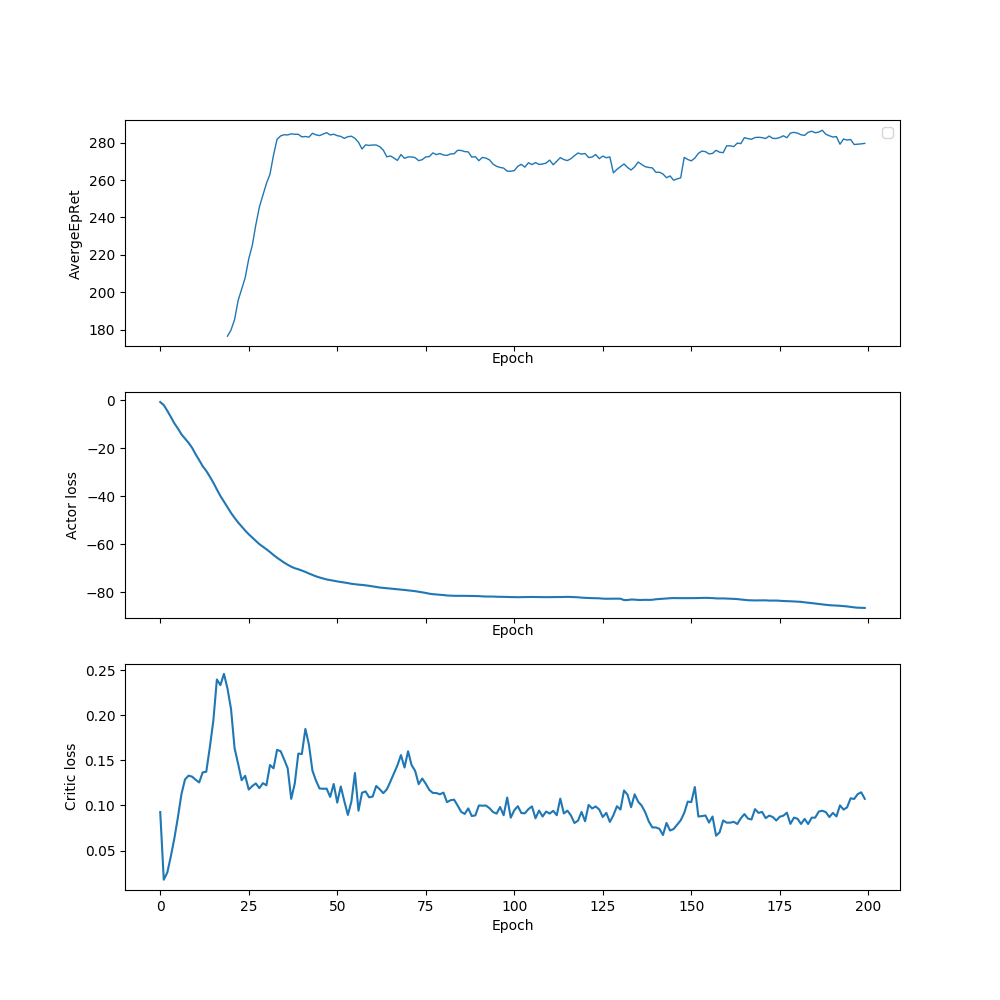

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


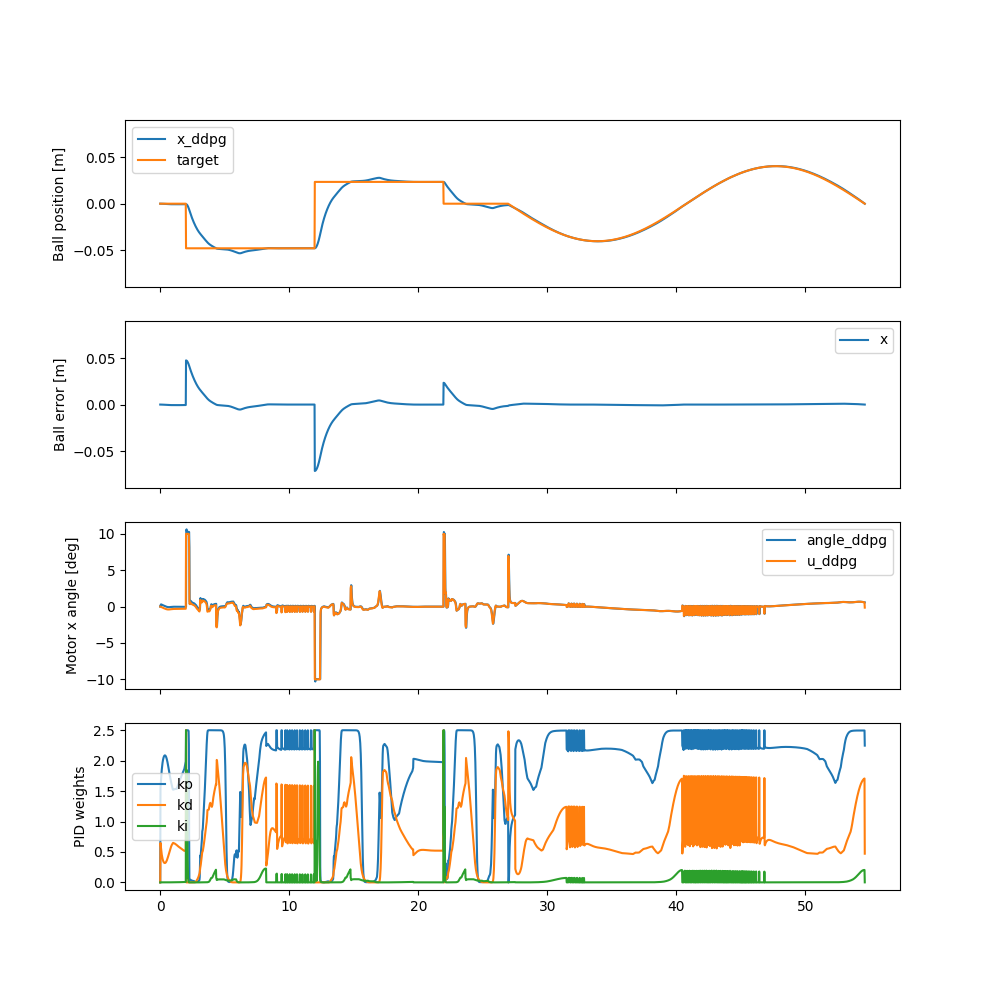

In [15]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[100]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[200]_relu_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            200
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3dc3de2748>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[200]_relu_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[200]_relu_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
 

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            82.2 |
|          StdEpRet |             5.1 |
|          MaxEpRet |            88.7 |
|          MinEpRet |            76.2 |
|  AverageTestEpRet |             240 |
|      StdTestEpRet |            24.5 |
|      MaxTestEpRet |             292 |
|      MinTestEpRet |             196 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            15.5 |
|          StdQVals |            4.89 |
|          MaxQVals |            25.7 |
|          MinQVals |           -22.4 |
|            LossPi |           -15.7 |
|             LossQ |          0.0673 |
|              Time |            56.4 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |             212 |
|          StdEpRet |             100 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             286 |
|          StdEpRet |            38.2 |
|          MaxEpRet |             336 |
|          MinEpRet |             244 |
|  AverageTestEpRet |             277 |
|      StdTestEpRet |            26.4 |
|      MaxTestEpRet |             317 |
|      MinTestEpRet |             207 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            35.4 |
|          StdQVals |             8.9 |
|          MaxQVals |            56.5 |
|          MinQVals |           -27.3 |
|            LossPi |           -35.6 |
|             LossQ |           0.144 |
|              Time |             131 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             308 |
|          StdEpRet |            28.1 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             274 |
|          StdEpRet |            25.4 |
|          MaxEpRet |             300 |
|          MinEpRet |             239 |
|  AverageTestEpRet |             311 |
|      StdTestEpRet |            20.7 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |              55 |
|          StdQVals |            10.9 |
|          MaxQVals |            72.7 |
|          MinQVals |           -23.9 |
|            LossPi |           -55.3 |
|             LossQ |           0.141 |
|              Time |             209 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             278 |
|          StdEpRet |             6.2 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             292 |
|          StdEpRet |            17.9 |
|          MaxEpRet |             307 |
|          MinEpRet |             267 |
|  AverageTestEpRet |             307 |
|      StdTestEpRet |            24.8 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             249 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |            65.8 |
|          StdQVals |            9.46 |
|          MaxQVals |            82.9 |
|          MinQVals |             -28 |
|            LossPi |             -66 |
|             LossQ |           0.171 |
|              Time |             302 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             295 |
|          StdEpRet |            11.6 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             301 |
|          StdEpRet |            4.62 |
|          MaxEpRet |             308 |
|          MinEpRet |             297 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            30.4 |
|      MaxTestEpRet |             347 |
|      MinTestEpRet |             247 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |            72.8 |
|          StdQVals |            9.33 |
|          MaxQVals |            86.8 |
|          MinQVals |            1.71 |
|            LossPi |             -73 |
|             LossQ |           0.147 |
|              Time |             414 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             318 |
|          StdEpRet |            16.4 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             274 |
|          StdEpRet |            50.4 |
|          MaxEpRet |             333 |
|          MinEpRet |             210 |
|  AverageTestEpRet |             289 |
|      StdTestEpRet |            31.8 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             233 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |            76.9 |
|          StdQVals |            8.31 |
|          MaxQVals |              89 |
|          MinQVals |            12.1 |
|            LossPi |           -77.1 |
|             LossQ |           0.102 |
|              Time |             531 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             251 |
|          StdEpRet |            13.1 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             280 |
|          StdEpRet |            6.07 |
|          MaxEpRet |             288 |
|          MinEpRet |             275 |
|  AverageTestEpRet |             296 |
|      StdTestEpRet |            30.9 |
|      MaxTestEpRet |             329 |
|      MinTestEpRet |             213 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            78.4 |
|          StdQVals |            8.81 |
|          MaxQVals |            95.8 |
|          MinQVals |            11.1 |
|            LossPi |           -78.5 |
|             LossQ |           0.116 |
|              Time |             630 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             279 |
|          StdEpRet |            1.39 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             254 |
|          StdEpRet |            29.2 |
|          MaxEpRet |             294 |
|          MinEpRet |             224 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            24.2 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             233 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            79.7 |
|          StdQVals |            7.69 |
|          MaxQVals |            93.7 |
|          MinQVals |            15.3 |
|            LossPi |           -79.7 |
|             LossQ |           0.113 |
|              Time |             721 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             236 |
|          StdEpRet |            19.2 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             293 |
|          StdEpRet |             2.9 |
|          MaxEpRet |             296 |
|          MinEpRet |             289 |
|  AverageTestEpRet |             291 |
|      StdTestEpRet |            24.5 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             236 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |            80.6 |
|          StdQVals |            6.51 |
|          MaxQVals |            92.1 |
|          MinQVals |              17 |
|            LossPi |           -80.7 |
|             LossQ |          0.0754 |
|              Time |             802 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             268 |
|          StdEpRet |            15.1 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             281 |
|          StdEpRet |              26 |
|          MaxEpRet |             314 |
|          MinEpRet |             250 |
|  AverageTestEpRet |             274 |
|      StdTestEpRet |            48.8 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             204 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |            81.2 |
|          StdQVals |            5.64 |
|          MaxQVals |            90.9 |
|          MinQVals |            26.7 |
|            LossPi |           -81.3 |
|             LossQ |            0.11 |
|              Time |             885 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             263 |
|          StdEpRet |              56 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             288 |
|          StdEpRet |            11.7 |
|          MaxEpRet |             301 |
|          MinEpRet |             273 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            24.1 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |             246 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |            81.7 |
|          StdQVals |            6.93 |
|          MaxQVals |            91.6 |
|          MinQVals |            11.8 |
|            LossPi |           -81.8 |
|             LossQ |          0.0913 |
|              Time |             960 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             265 |
|          StdEpRet |            16.8 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             303 |
|          StdEpRet |            15.8 |
|          MaxEpRet |             325 |
|          MinEpRet |             287 |
|  AverageTestEpRet |             317 |
|      StdTestEpRet |            18.7 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             272 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |            83.1 |
|          StdQVals |            7.94 |
|          MaxQVals |            94.3 |
|          MinQVals |            18.4 |
|            LossPi |           -83.3 |
|             LossQ |           0.099 |
|              Time |        1.04e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             294 |
|          StdEpRet |            16.5 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             301 |
|          StdEpRet |            16.6 |
|          MaxEpRet |             322 |
|          MinEpRet |             282 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            15.4 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             278 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |            83.7 |
|          StdQVals |            7.79 |
|          MaxQVals |            94.8 |
|          MinQVals |           -13.6 |
|            LossPi |           -83.8 |
|             LossQ |           0.104 |
|              Time |        1.12e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |             283 |
|          StdEpRet |            8.64 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             314 |
|          StdEpRet |            2.02 |
|          MaxEpRet |             316 |
|          MinEpRet |             311 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |            24.6 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             256 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            84.2 |
|          StdQVals |            7.58 |
|          MaxQVals |            95.2 |
|          MinQVals |            20.5 |
|            LossPi |           -84.4 |
|             LossQ |          0.0786 |
|              Time |         1.2e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             242 |
|          StdEpRet |            22.9 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             262 |
|          StdEpRet |            24.4 |
|          MaxEpRet |             286 |
|          MinEpRet |             228 |
|  AverageTestEpRet |             256 |
|      StdTestEpRet |            48.9 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             195 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |            85.1 |
|          StdQVals |            7.44 |
|          MaxQVals |            97.4 |
|          MinQVals |            22.8 |
|            LossPi |           -85.2 |
|             LossQ |          0.0822 |
|              Time |        1.28e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             228 |
|          StdEpRet |            29.4 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             267 |
|          StdEpRet |            31.4 |
|          MaxEpRet |             296 |
|          MinEpRet |             223 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            20.8 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             263 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            83.6 |
|          StdQVals |             8.1 |
|          MaxQVals |              96 |
|          MinQVals |            12.9 |
|            LossPi |           -83.7 |
|             LossQ |          0.0787 |
|              Time |        1.36e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             259 |
|          StdEpRet |            32.5 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             213 |
|          StdEpRet |             114 |
|          MaxEpRet |             317 |
|          MinEpRet |              55 |
|  AverageTestEpRet |             295 |
|      StdTestEpRet |              29 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             241 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            85.5 |
|          StdQVals |            7.56 |
|          MaxQVals |             102 |
|          MinQVals |            14.2 |
|            LossPi |           -85.7 |
|             LossQ |          0.0769 |
|              Time |        1.43e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             255 |
|          StdEpRet |            29.7 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             273 |
|          StdEpRet |            31.3 |
|          MaxEpRet |             305 |
|          MinEpRet |             230 |
|  AverageTestEpRet |             282 |
|      StdTestEpRet |              27 |
|      MaxTestEpRet |             326 |
|      MinTestEpRet |             234 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |            84.8 |
|          StdQVals |            7.68 |
|          MaxQVals |            96.6 |
|          MinQVals |            29.2 |
|            LossPi |           -84.9 |
|             LossQ |           0.064 |
|              Time |         1.5e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             306 |
|          StdEpRet |            6.23 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             280 |
|          StdEpRet |            65.3 |
|          MaxEpRet |             341 |
|          MinEpRet |             189 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |              27 |
|      MaxTestEpRet |             331 |
|      MinTestEpRet |             219 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |            84.9 |
|          StdQVals |            8.94 |
|          MaxQVals |            95.9 |
|          MinQVals |            19.4 |
|            LossPi |             -85 |
|             LossQ |          0.0747 |
|              Time |        1.57e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             307 |
|          StdEpRet |            28.8 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             291 |
|          StdEpRet |              21 |
|          MaxEpRet |             317 |
|          MinEpRet |             265 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            22.4 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             254 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |              85 |
|          StdQVals |            8.93 |
|          MaxQVals |            95.2 |
|          MinQVals |            11.9 |
|            LossPi |             -85 |
|             LossQ |           0.058 |
|              Time |        1.65e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             302 |
|          StdEpRet |            30.9 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.19704561135632717


<IPython.core.display.Javascript object>


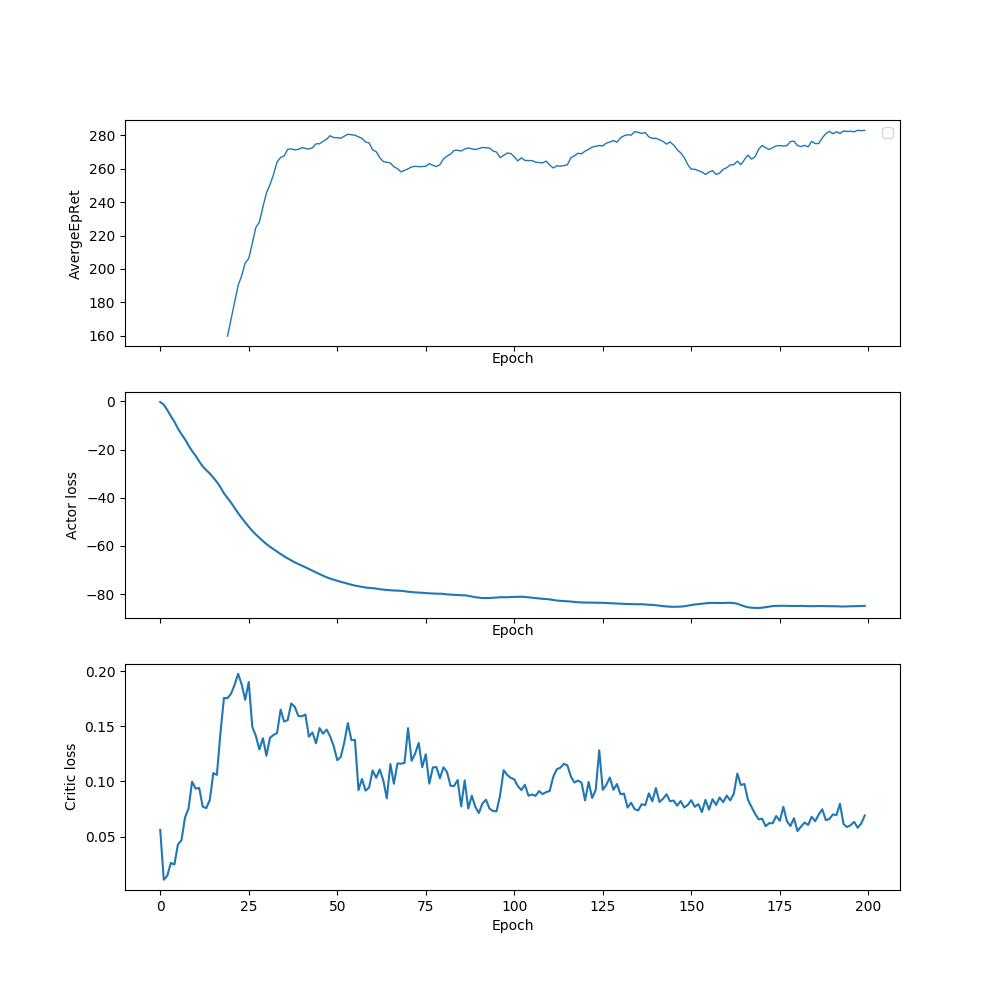

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


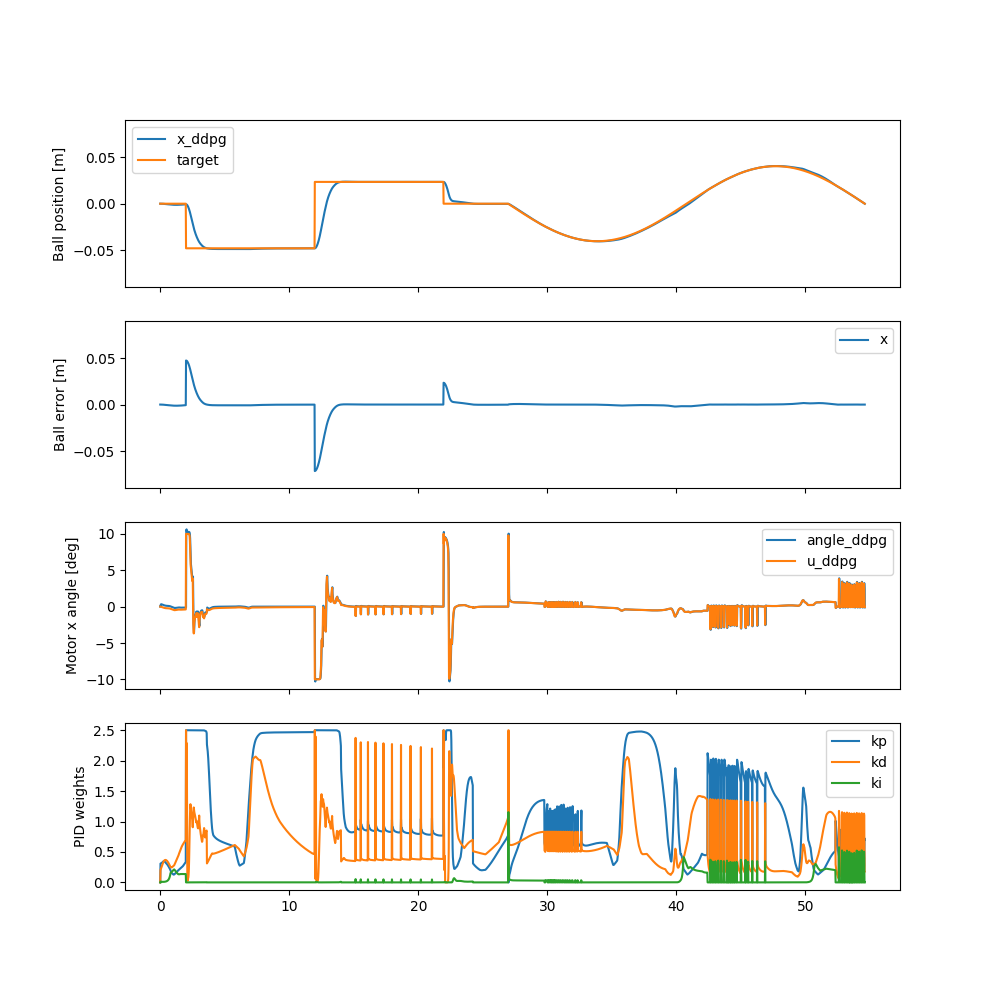

In [16]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[200]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50]_sigmoid_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            50
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3dc3f08b70>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50]_sigmoid_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50]_sigmoid_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
           

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            88.8 |
|          StdEpRet |            22.6 |
|          MaxEpRet |             119 |
|          MinEpRet |              64 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |            28.1 |
|      MaxTestEpRet |             337 |
|      MinTestEpRet |             250 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |              14 |
|          StdQVals |            6.06 |
|          MaxQVals |              28 |
|          MinQVals |           -4.88 |
|            LossPi |           -14.2 |
|             LossQ |           0.289 |
|              Time |              51 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            90.4 |
|          StdEpRet |            5.56 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             243 |
|          StdEpRet |            5.39 |
|          MaxEpRet |             251 |
|          MinEpRet |             239 |
|  AverageTestEpRet |             272 |
|      StdTestEpRet |            29.8 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             225 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            34.3 |
|          StdQVals |            9.86 |
|          MaxQVals |            56.8 |
|          MinQVals |           -4.58 |
|            LossPi |           -34.6 |
|             LossQ |           0.149 |
|              Time |             119 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             270 |
|          StdEpRet |              41 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             288 |
|          StdEpRet |            28.1 |
|          MaxEpRet |             327 |
|          MinEpRet |             264 |
|  AverageTestEpRet |             295 |
|      StdTestEpRet |            16.8 |
|      MaxTestEpRet |             318 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |            54.4 |
|          StdQVals |              11 |
|          MaxQVals |            73.4 |
|          MinQVals |          -0.252 |
|            LossPi |           -54.6 |
|             LossQ |           0.187 |
|              Time |             192 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             269 |
|          StdEpRet |            4.78 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             301 |
|          StdEpRet |            24.1 |
|          MaxEpRet |             325 |
|          MinEpRet |             268 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            22.2 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             253 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |            66.4 |
|          StdQVals |            9.47 |
|          MaxQVals |            81.4 |
|          MinQVals |            6.32 |
|            LossPi |           -66.6 |
|             LossQ |           0.135 |
|              Time |             264 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             269 |
|          StdEpRet |            12.8 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             265 |
|          StdEpRet |            10.7 |
|          MaxEpRet |             274 |
|          MinEpRet |             250 |
|  AverageTestEpRet |             291 |
|      StdTestEpRet |            19.2 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |             246 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |            71.6 |
|          StdQVals |            9.14 |
|          MaxQVals |            85.4 |
|          MinQVals |            11.3 |
|            LossPi |           -71.8 |
|             LossQ |           0.105 |
|              Time |             332 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             335 |
|          StdEpRet |           0.322 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             288 |
|          StdEpRet |            29.8 |
|          MaxEpRet |             318 |
|          MinEpRet |             247 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            22.8 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             266 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |            74.8 |
|          StdQVals |            8.51 |
|          MaxQVals |            86.6 |
|          MinQVals |              14 |
|            LossPi |           -74.9 |
|             LossQ |            0.08 |
|              Time |             403 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             292 |
|          StdEpRet |            23.6 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             288 |
|          StdEpRet |            7.93 |
|          MaxEpRet |             298 |
|          MinEpRet |             279 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            24.3 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             246 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            76.6 |
|          StdQVals |            8.23 |
|          MaxQVals |            87.7 |
|          MinQVals |            16.2 |
|            LossPi |           -76.7 |
|             LossQ |          0.0605 |
|              Time |             477 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             281 |
|          StdEpRet |            14.5 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             286 |
|          StdEpRet |            8.14 |
|          MaxEpRet |             296 |
|          MinEpRet |             276 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            24.1 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            78.6 |
|          StdQVals |            7.81 |
|          MaxQVals |            89.3 |
|          MinQVals |            18.7 |
|            LossPi |           -78.7 |
|             LossQ |          0.0663 |
|              Time |             547 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             285 |
|          StdEpRet |            9.62 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             276 |
|          StdEpRet |            29.5 |
|          MaxEpRet |             317 |
|          MinEpRet |             248 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            23.6 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             266 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |            80.5 |
|          StdQVals |            7.51 |
|          MaxQVals |            90.7 |
|          MinQVals |            18.7 |
|            LossPi |           -80.5 |
|             LossQ |          0.0464 |
|              Time |             619 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             245 |
|          StdEpRet |            2.04 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             276 |
|          StdEpRet |            30.6 |
|          MaxEpRet |             320 |
|          MinEpRet |             254 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            25.5 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             256 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |            81.3 |
|          StdQVals |            7.49 |
|          MaxQVals |            91.2 |
|          MinQVals |            22.9 |
|            LossPi |           -81.3 |
|             LossQ |          0.0454 |
|              Time |             686 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             289 |
|          StdEpRet |            15.8 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             282 |
|          StdEpRet |            30.8 |
|          MaxEpRet |             318 |
|          MinEpRet |             243 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            25.6 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |            81.6 |
|          StdQVals |            7.53 |
|          MaxQVals |            91.1 |
|          MinQVals |            23.9 |
|            LossPi |           -81.6 |
|             LossQ |          0.0375 |
|              Time |             762 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             292 |
|          StdEpRet |            3.31 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             276 |
|          StdEpRet |            10.5 |
|          MaxEpRet |             285 |
|          MinEpRet |             261 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            22.4 |
|      MaxTestEpRet |             347 |
|      MinTestEpRet |             266 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |            82.1 |
|          StdQVals |            7.34 |
|          MaxQVals |              91 |
|          MinQVals |              21 |
|            LossPi |           -82.1 |
|             LossQ |          0.0414 |
|              Time |             833 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             297 |
|          StdEpRet |            35.9 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             308 |
|          StdEpRet |            16.1 |
|          MaxEpRet |             331 |
|          MinEpRet |             297 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |            23.5 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |            82.8 |
|          StdQVals |            7.57 |
|          MaxQVals |            92.3 |
|          MinQVals |            21.6 |
|            LossPi |           -82.8 |
|             LossQ |          0.0414 |
|              Time |             906 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |             270 |
|          StdEpRet |            4.06 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             282 |
|          StdEpRet |            16.9 |
|          MaxEpRet |             303 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             295 |
|      StdTestEpRet |              25 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             242 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            83.3 |
|          StdQVals |            7.58 |
|          MaxQVals |            92.2 |
|          MinQVals |            22.9 |
|            LossPi |           -83.4 |
|             LossQ |          0.0453 |
|              Time |             975 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             297 |
|          StdEpRet |            9.27 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             268 |
|          StdEpRet |            21.7 |
|          MaxEpRet |             298 |
|          MinEpRet |             248 |
|  AverageTestEpRet |             294 |
|      StdTestEpRet |            22.3 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             255 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |              84 |
|          StdQVals |            7.71 |
|          MaxQVals |            95.3 |
|          MinQVals |            28.6 |
|            LossPi |           -84.1 |
|             LossQ |          0.0648 |
|              Time |        1.05e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             266 |
|          StdEpRet |            1.75 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             283 |
|          StdEpRet |            32.5 |
|          MaxEpRet |             327 |
|          MinEpRet |             249 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |            33.5 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             208 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            84.5 |
|          StdQVals |            7.76 |
|          MaxQVals |            94.6 |
|          MinQVals |            29.2 |
|            LossPi |           -84.5 |
|             LossQ |           0.058 |
|              Time |        1.12e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             255 |
|          StdEpRet |            23.1 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             311 |
|          StdEpRet |            26.4 |
|          MaxEpRet |             347 |
|          MinEpRet |             287 |
|  AverageTestEpRet |             278 |
|      StdTestEpRet |            26.2 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             228 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            84.6 |
|          StdQVals |            7.74 |
|          MaxQVals |            94.8 |
|          MinQVals |            30.3 |
|            LossPi |           -84.7 |
|             LossQ |          0.0845 |
|              Time |        1.19e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             287 |
|          StdEpRet |            10.9 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             294 |
|          StdEpRet |            3.25 |
|          MaxEpRet |             297 |
|          MinEpRet |             289 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            17.6 |
|      MaxTestEpRet |             330 |
|      MinTestEpRet |             254 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |            84.8 |
|          StdQVals |             8.2 |
|          MaxQVals |            95.5 |
|          MinQVals |            28.4 |
|            LossPi |           -84.9 |
|             LossQ |          0.0918 |
|              Time |        1.26e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             271 |
|          StdEpRet |            22.1 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             283 |
|          StdEpRet |            17.7 |
|          MaxEpRet |             305 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            23.9 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |              84 |
|          StdQVals |            8.68 |
|          MaxQVals |            94.4 |
|          MinQVals |            24.5 |
|            LossPi |             -84 |
|             LossQ |          0.0726 |
|              Time |        1.33e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             289 |
|          StdEpRet |            13.8 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             266 |
|          StdEpRet |            28.2 |
|          MaxEpRet |             286 |
|          MinEpRet |             226 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            26.7 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |            83.7 |
|          StdQVals |            8.64 |
|          MaxQVals |            93.6 |
|          MinQVals |            27.3 |
|            LossPi |           -83.8 |
|             LossQ |          0.0792 |
|              Time |         1.4e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             292 |
|          StdEpRet |            43.8 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.2055302401693574


<IPython.core.display.Javascript object>


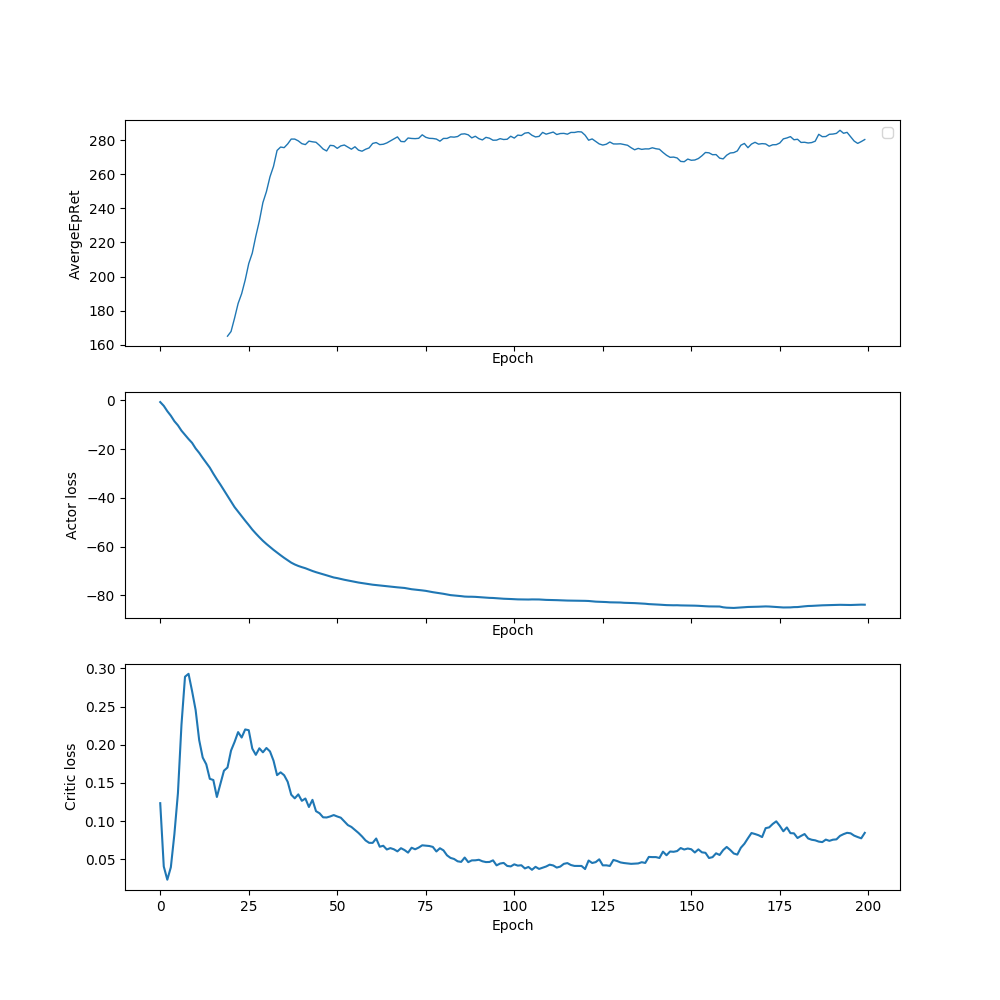

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


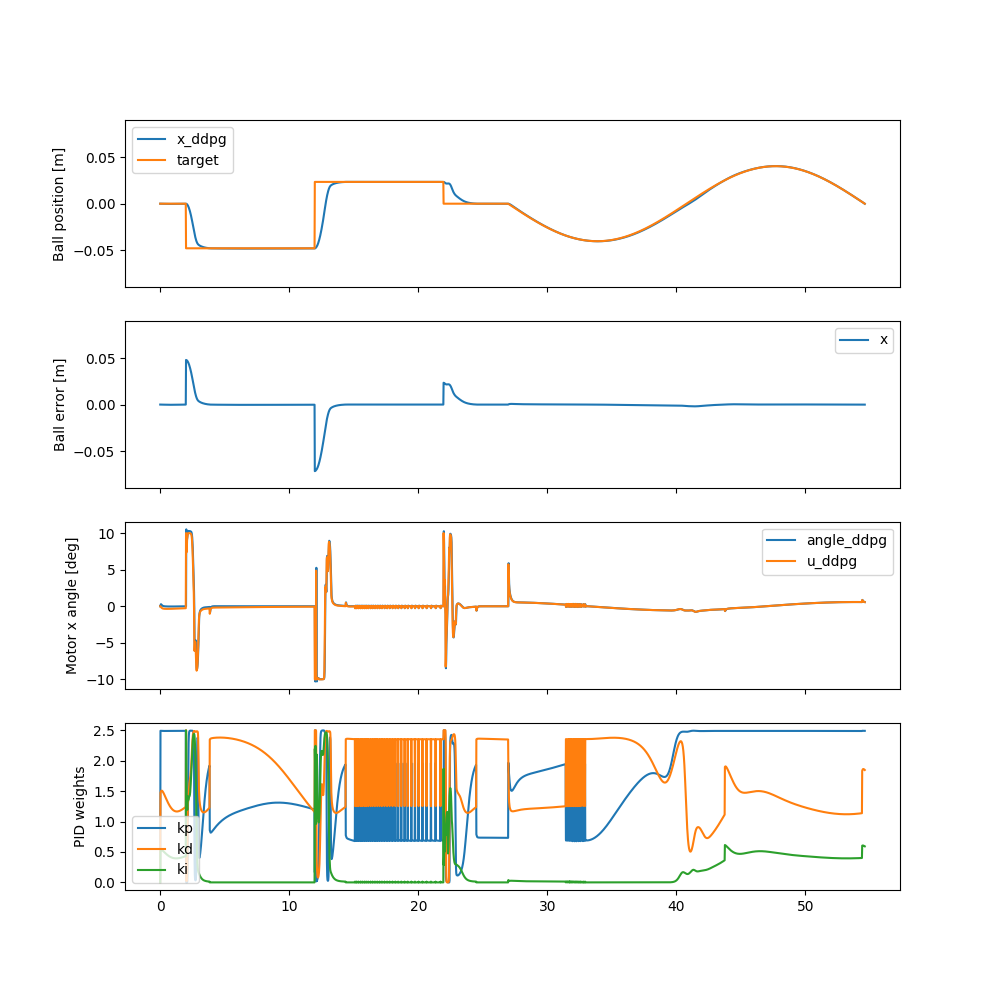

In [17]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50] 
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100]_sigmoid_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3dc3f08ac8>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100]_sigmoid_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100]_sigmoid_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
       

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |             120 |
|          StdEpRet |              83 |
|          MaxEpRet |             237 |
|          MinEpRet |            53.5 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            22.6 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             254 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            12.8 |
|          StdQVals |            4.31 |
|          MaxQVals |            24.4 |
|          MinQVals |           -8.41 |
|            LossPi |             -13 |
|             LossQ |           0.182 |
|              Time |            56.4 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            90.1 |
|          StdEpRet |           0.229 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             271 |
|          StdEpRet |            13.1 |
|          MaxEpRet |             280 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |              29 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             226 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            35.8 |
|          StdQVals |            9.15 |
|          MaxQVals |            53.5 |
|          MinQVals |           -8.56 |
|            LossPi |           -36.1 |
|             LossQ |            0.12 |
|              Time |             131 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             264 |
|          StdEpRet |            17.9 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             276 |
|          StdEpRet |            46.9 |
|          MaxEpRet |             340 |
|          MinEpRet |             228 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            27.2 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |            53.6 |
|          StdQVals |            9.34 |
|          MaxQVals |            69.8 |
|          MinQVals |           -1.72 |
|            LossPi |           -53.8 |
|             LossQ |            0.11 |
|              Time |             208 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             266 |
|          StdEpRet |            26.4 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             282 |
|          StdEpRet |            20.4 |
|          MaxEpRet |             303 |
|          MinEpRet |             254 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            18.8 |
|      MaxTestEpRet |             337 |
|      MinTestEpRet |             267 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |            64.5 |
|          StdQVals |            9.09 |
|          MaxQVals |              81 |
|          MinQVals |            8.21 |
|            LossPi |           -64.6 |
|             LossQ |          0.0867 |
|              Time |             282 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             274 |
|          StdEpRet |            26.8 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             307 |
|          StdEpRet |            25.7 |
|          MaxEpRet |             328 |
|          MinEpRet |             271 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            25.1 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             246 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |            71.1 |
|          StdQVals |            9.19 |
|          MaxQVals |            85.5 |
|          MinQVals |            17.5 |
|            LossPi |           -71.2 |
|             LossQ |           0.071 |
|              Time |             358 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             307 |
|          StdEpRet |            16.2 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             291 |
|          StdEpRet |            7.07 |
|          MaxEpRet |             300 |
|          MinEpRet |             284 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            27.9 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             253 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |            74.8 |
|          StdQVals |            8.67 |
|          MaxQVals |            86.7 |
|          MinQVals |            16.1 |
|            LossPi |           -74.9 |
|             LossQ |          0.0582 |
|              Time |             436 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             296 |
|          StdEpRet |            29.6 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             260 |
|          StdEpRet |            28.8 |
|          MaxEpRet |             301 |
|          MinEpRet |             236 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            24.8 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            76.7 |
|          StdQVals |            8.53 |
|          MaxQVals |            87.4 |
|          MinQVals |            19.1 |
|            LossPi |           -76.8 |
|             LossQ |          0.0511 |
|              Time |             511 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             289 |
|          StdEpRet |            4.97 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             311 |
|          StdEpRet |            22.1 |
|          MaxEpRet |             341 |
|          MinEpRet |             289 |
|  AverageTestEpRet |             309 |
|      StdTestEpRet |            25.2 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            79.1 |
|          StdQVals |            8.18 |
|          MaxQVals |            88.8 |
|          MinQVals |            21.1 |
|            LossPi |           -79.2 |
|             LossQ |          0.0467 |
|              Time |             589 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             286 |
|          StdEpRet |            13.7 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             271 |
|          StdEpRet |            29.8 |
|          MaxEpRet |             305 |
|          MinEpRet |             232 |
|  AverageTestEpRet |             316 |
|      StdTestEpRet |            18.4 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             269 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |            80.8 |
|          StdQVals |             7.9 |
|          MaxQVals |              89 |
|          MinQVals |            21.1 |
|            LossPi |           -80.8 |
|             LossQ |          0.0396 |
|              Time |             664 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             306 |
|          StdEpRet |            10.6 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             302 |
|          StdEpRet |            1.87 |
|          MaxEpRet |             304 |
|          MinEpRet |             299 |
|  AverageTestEpRet |             297 |
|      StdTestEpRet |              22 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |              82 |
|          StdQVals |            7.48 |
|          MaxQVals |            89.4 |
|          MinQVals |            21.8 |
|            LossPi |             -82 |
|             LossQ |          0.0404 |
|              Time |             740 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             287 |
|          StdEpRet |            1.69 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             294 |
|          StdEpRet |            35.4 |
|          MaxEpRet |             339 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |              23 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             256 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |            82.8 |
|          StdQVals |            7.21 |
|          MaxQVals |            90.1 |
|          MinQVals |              27 |
|            LossPi |           -82.9 |
|             LossQ |          0.0363 |
|              Time |             814 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             305 |
|          StdEpRet |            8.04 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             260 |
|          StdEpRet |            31.3 |
|          MaxEpRet |             290 |
|          MinEpRet |             217 |
|  AverageTestEpRet |             279 |
|      StdTestEpRet |            38.9 |
|      MaxTestEpRet |             324 |
|      MinTestEpRet |             215 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |            83.1 |
|          StdQVals |            7.29 |
|          MaxQVals |            89.9 |
|          MinQVals |              23 |
|            LossPi |           -83.1 |
|             LossQ |           0.045 |
|              Time |             888 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             250 |
|          StdEpRet |            45.6 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             292 |
|          StdEpRet |            8.26 |
|          MaxEpRet |             303 |
|          MinEpRet |             284 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            22.3 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |            83.2 |
|          StdQVals |            7.02 |
|          MaxQVals |            90.2 |
|          MinQVals |            28.7 |
|            LossPi |           -83.3 |
|             LossQ |          0.0569 |
|              Time |             963 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |             314 |
|          StdEpRet |            9.41 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             263 |
|          StdEpRet |            4.75 |
|          MaxEpRet |             269 |
|          MinEpRet |             257 |
|  AverageTestEpRet |             309 |
|      StdTestEpRet |            19.9 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |             270 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            83.6 |
|          StdQVals |            7.16 |
|          MaxQVals |            91.7 |
|          MinQVals |            28.5 |
|            LossPi |           -83.7 |
|             LossQ |          0.0476 |
|              Time |        1.04e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             298 |
|          StdEpRet |            31.4 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             295 |
|          StdEpRet |            29.3 |
|          MaxEpRet |             334 |
|          MinEpRet |             263 |
|  AverageTestEpRet |             312 |
|      StdTestEpRet |            23.4 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             256 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |            83.6 |
|          StdQVals |               7 |
|          MaxQVals |            92.6 |
|          MinQVals |              31 |
|            LossPi |           -83.7 |
|             LossQ |          0.0458 |
|              Time |        1.11e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             301 |
|          StdEpRet |            12.7 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             275 |
|          StdEpRet |            14.7 |
|          MaxEpRet |             295 |
|          MinEpRet |             260 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            17.1 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |             269 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            83.6 |
|          StdQVals |            7.13 |
|          MaxQVals |            92.3 |
|          MinQVals |            28.4 |
|            LossPi |           -83.6 |
|             LossQ |          0.0453 |
|              Time |        1.19e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             304 |
|          StdEpRet |            8.32 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             288 |
|          StdEpRet |            18.6 |
|          MaxEpRet |             303 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            29.2 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             248 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            83.2 |
|          StdQVals |            7.32 |
|          MaxQVals |              92 |
|          MinQVals |            28.1 |
|            LossPi |           -83.3 |
|             LossQ |            0.04 |
|              Time |        1.27e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             288 |
|          StdEpRet |            6.27 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             292 |
|          StdEpRet |            20.3 |
|          MaxEpRet |             312 |
|          MinEpRet |             264 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |              31 |
|      MaxTestEpRet |             347 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |            83.1 |
|          StdQVals |            7.43 |
|          MaxQVals |            91.9 |
|          MinQVals |            25.7 |
|            LossPi |           -83.2 |
|             LossQ |           0.035 |
|              Time |        1.34e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             292 |
|          StdEpRet |            36.7 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             261 |
|          StdEpRet |              10 |
|          MaxEpRet |             275 |
|          MinEpRet |             252 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            25.7 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |            82.8 |
|          StdQVals |            7.33 |
|          MaxQVals |            92.1 |
|          MinQVals |            24.9 |
|            LossPi |           -82.8 |
|             LossQ |           0.039 |
|              Time |        1.42e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             277 |
|          StdEpRet |            22.6 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             287 |
|          StdEpRet |            2.36 |
|          MaxEpRet |             290 |
|          MinEpRet |             284 |
|  AverageTestEpRet |             312 |
|      StdTestEpRet |            19.7 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             274 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |            82.4 |
|          StdQVals |            7.31 |
|          MaxQVals |            91.5 |
|          MinQVals |            25.6 |
|            LossPi |           -82.5 |
|             LossQ |          0.0405 |
|              Time |        1.49e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             323 |
|          StdEpRet |              17 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.19587952105017892


<IPython.core.display.Javascript object>


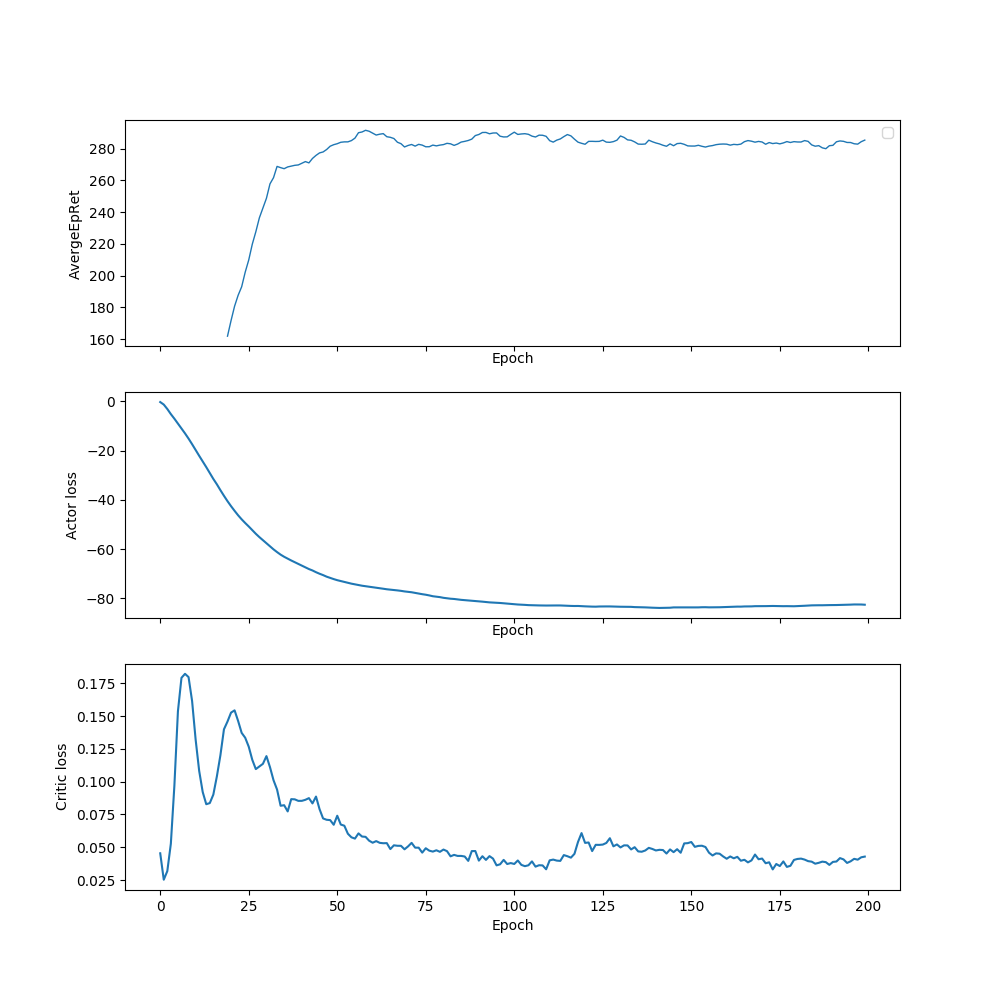

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


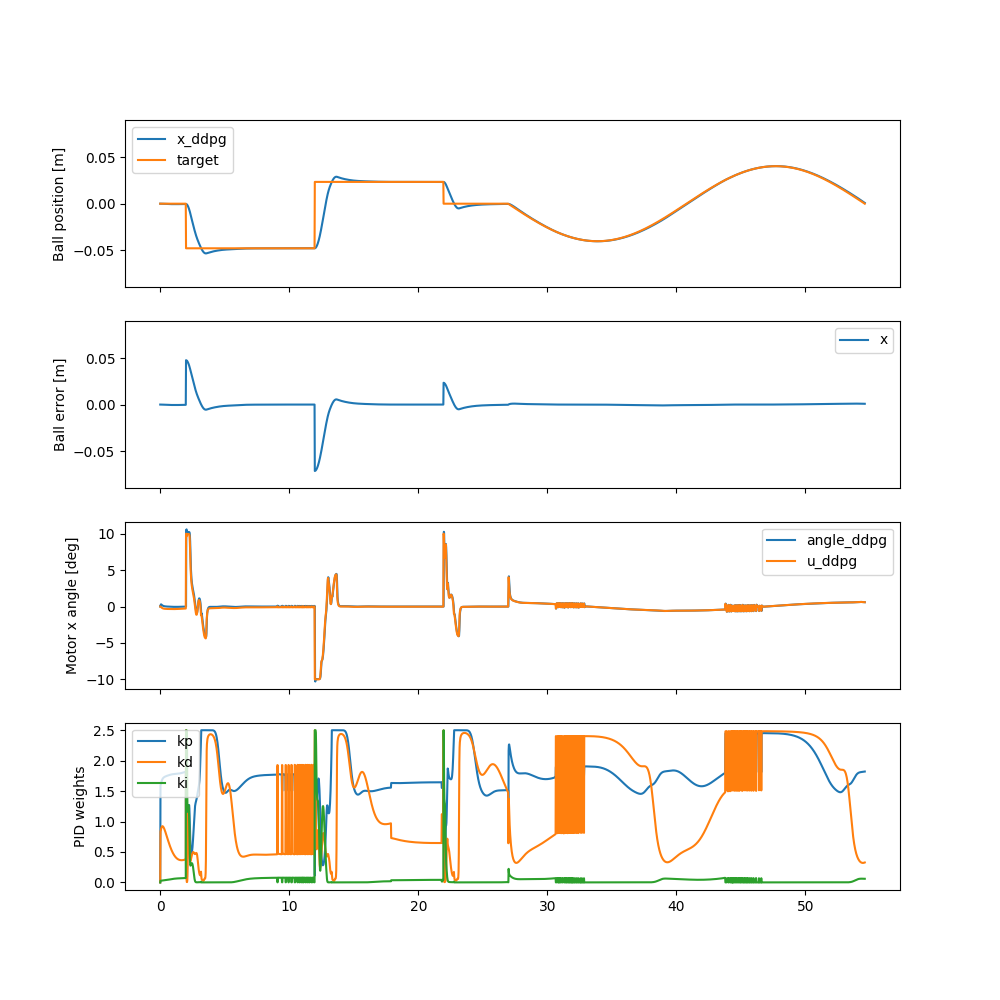

In [18]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[200]_sigmoid_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            200
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3dc3df3cc0>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[200]_sigmoid_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[200]_sigmoid_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
       

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            84.8 |
|          StdEpRet |            12.4 |
|          MaxEpRet |            96.3 |
|          MinEpRet |            67.6 |
|  AverageTestEpRet |             289 |
|      StdTestEpRet |            27.8 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |             225 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            11.7 |
|          StdQVals |            4.41 |
|          MaxQVals |            20.7 |
|          MinQVals |           -7.05 |
|            LossPi |           -11.8 |
|             LossQ |           0.318 |
|              Time |            67.3 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            60.5 |
|          StdEpRet |            1.48 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             258 |
|          StdEpRet |            7.54 |
|          MaxEpRet |             268 |
|          MinEpRet |             250 |
|  AverageTestEpRet |             297 |
|      StdTestEpRet |            18.9 |
|      MaxTestEpRet |             337 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            33.5 |
|          StdQVals |            8.19 |
|          MaxQVals |            51.7 |
|          MinQVals |           -5.58 |
|            LossPi |           -33.7 |
|             LossQ |           0.106 |
|              Time |             156 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             266 |
|          StdEpRet |            13.4 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             276 |
|          StdEpRet |            15.9 |
|          MaxEpRet |             296 |
|          MinEpRet |             257 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            20.8 |
|      MaxTestEpRet |             329 |
|      MinTestEpRet |             249 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |              52 |
|          StdQVals |            9.63 |
|          MaxQVals |            69.6 |
|          MinQVals |            3.64 |
|            LossPi |           -52.2 |
|             LossQ |          0.0812 |
|              Time |             245 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             294 |
|          StdEpRet |            29.9 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             268 |
|          StdEpRet |            20.2 |
|          MaxEpRet |             284 |
|          MinEpRet |             240 |
|  AverageTestEpRet |             297 |
|      StdTestEpRet |            24.5 |
|      MaxTestEpRet |             337 |
|      MinTestEpRet |             247 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |            63.7 |
|          StdQVals |            9.38 |
|          MaxQVals |              79 |
|          MinQVals |            12.6 |
|            LossPi |           -63.9 |
|             LossQ |          0.0684 |
|              Time |             340 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             305 |
|          StdEpRet |            18.5 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             291 |
|          StdEpRet |            10.4 |
|          MaxEpRet |             304 |
|          MinEpRet |             280 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            28.8 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             252 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |            70.4 |
|          StdQVals |            8.86 |
|          MaxQVals |            83.2 |
|          MinQVals |            18.2 |
|            LossPi |           -70.6 |
|             LossQ |          0.0506 |
|              Time |             432 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             309 |
|          StdEpRet |              20 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             276 |
|          StdEpRet |            12.2 |
|          MaxEpRet |             291 |
|          MinEpRet |             261 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            37.7 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             211 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |              74 |
|          StdQVals |            8.64 |
|          MaxQVals |            84.7 |
|          MinQVals |            26.5 |
|            LossPi |           -74.1 |
|             LossQ |          0.0506 |
|              Time |             521 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             294 |
|          StdEpRet |            1.28 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             270 |
|          StdEpRet |            23.1 |
|          MaxEpRet |             300 |
|          MinEpRet |             245 |
|  AverageTestEpRet |             311 |
|      StdTestEpRet |            19.9 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            75.9 |
|          StdQVals |            8.23 |
|          MaxQVals |            85.5 |
|          MinQVals |            25.8 |
|            LossPi |             -76 |
|             LossQ |          0.0465 |
|              Time |             609 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             267 |
|          StdEpRet |           0.338 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             266 |
|          StdEpRet |            32.5 |
|          MaxEpRet |             311 |
|          MinEpRet |             238 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            20.3 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            77.7 |
|          StdQVals |            7.43 |
|          MaxQVals |              86 |
|          MinQVals |            27.1 |
|            LossPi |           -77.7 |
|             LossQ |          0.0398 |
|              Time |             697 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             266 |
|          StdEpRet |            24.6 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             217 |
|          StdEpRet |            84.9 |
|          MaxEpRet |             295 |
|          MinEpRet |            98.9 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            18.3 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |            78.8 |
|          StdQVals |            7.68 |
|          MaxQVals |            87.1 |
|          MinQVals |              24 |
|            LossPi |           -78.8 |
|             LossQ |          0.0356 |
|              Time |             785 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             266 |
|          StdEpRet |            4.54 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             279 |
|          StdEpRet |            3.09 |
|          MaxEpRet |             282 |
|          MinEpRet |             275 |
|  AverageTestEpRet |             288 |
|      StdTestEpRet |            19.1 |
|      MaxTestEpRet |             325 |
|      MinTestEpRet |             244 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |            80.6 |
|          StdQVals |            8.12 |
|          MaxQVals |            96.9 |
|          MinQVals |            24.1 |
|            LossPi |           -80.8 |
|             LossQ |           0.126 |
|              Time |             875 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             280 |
|          StdEpRet |              40 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             275 |
|          StdEpRet |            16.9 |
|          MaxEpRet |             295 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             284 |
|      StdTestEpRet |            26.6 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |             246 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |            83.8 |
|          StdQVals |            8.93 |
|          MaxQVals |            96.6 |
|          MinQVals |            28.1 |
|            LossPi |           -83.8 |
|             LossQ |          0.0551 |
|              Time |             966 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             254 |
|          StdEpRet |            15.2 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             293 |
|          StdEpRet |            10.3 |
|          MaxEpRet |             302 |
|          MinEpRet |             278 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |            22.1 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             252 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |            84.2 |
|          StdQVals |            8.33 |
|          MaxQVals |            92.9 |
|          MinQVals |            28.3 |
|            LossPi |           -84.2 |
|             LossQ |          0.0365 |
|              Time |        1.05e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             287 |
|          StdEpRet |            8.42 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             304 |
|          StdEpRet |            20.2 |
|          MaxEpRet |             325 |
|          MinEpRet |             277 |
|  AverageTestEpRet |             317 |
|      StdTestEpRet |            20.4 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             267 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |            84.2 |
|          StdQVals |            8.05 |
|          MaxQVals |            91.2 |
|          MinQVals |            27.8 |
|            LossPi |           -84.3 |
|             LossQ |          0.0333 |
|              Time |        1.15e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |             312 |
|          StdEpRet |            22.8 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             261 |
|          StdEpRet |            18.3 |
|          MaxEpRet |             286 |
|          MinEpRet |             243 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            23.5 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            84.2 |
|          StdQVals |            7.89 |
|          MaxQVals |            89.9 |
|          MinQVals |            28.2 |
|            LossPi |           -84.2 |
|             LossQ |          0.0329 |
|              Time |        1.24e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             270 |
|          StdEpRet |            10.4 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             256 |
|          StdEpRet |            24.1 |
|          MaxEpRet |             290 |
|          MinEpRet |             238 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            22.1 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             255 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |            83.9 |
|          StdQVals |            8.11 |
|          MaxQVals |            89.1 |
|          MinQVals |            26.4 |
|            LossPi |           -83.9 |
|             LossQ |          0.0321 |
|              Time |        1.32e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             301 |
|          StdEpRet |            3.81 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             269 |
|          StdEpRet |            20.5 |
|          MaxEpRet |             297 |
|          MinEpRet |             250 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            22.6 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |             252 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            83.9 |
|          StdQVals |            7.29 |
|          MaxQVals |            88.8 |
|          MinQVals |            26.3 |
|            LossPi |             -84 |
|             LossQ |          0.0317 |
|              Time |        1.41e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             299 |
|          StdEpRet |            23.3 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             295 |
|          StdEpRet |            32.2 |
|          MaxEpRet |             339 |
|          MinEpRet |             263 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            23.8 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             244 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            83.8 |
|          StdQVals |            7.27 |
|          MaxQVals |            88.5 |
|          MinQVals |            26.7 |
|            LossPi |           -83.8 |
|             LossQ |          0.0313 |
|              Time |        1.51e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             268 |
|          StdEpRet |            9.79 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             278 |
|          StdEpRet |            32.4 |
|          MaxEpRet |             304 |
|          MinEpRet |             233 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |            28.8 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             247 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |            83.6 |
|          StdQVals |            7.07 |
|          MaxQVals |            88.2 |
|          MinQVals |            26.7 |
|            LossPi |           -83.7 |
|             LossQ |          0.0289 |
|              Time |         1.6e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             284 |
|          StdEpRet |            22.9 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             256 |
|          StdEpRet |            15.1 |
|          MaxEpRet |             277 |
|          MinEpRet |             244 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            22.9 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |            83.3 |
|          StdQVals |            7.25 |
|          MaxQVals |            88.2 |
|          MinQVals |              25 |
|            LossPi |           -83.3 |
|             LossQ |          0.0345 |
|              Time |        1.69e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             269 |
|          StdEpRet |            4.92 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             280 |
|          StdEpRet |            18.7 |
|          MaxEpRet |             301 |
|          MinEpRet |             256 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            26.3 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             253 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |              83 |
|          StdQVals |            7.38 |
|          MaxQVals |            88.2 |
|          MinQVals |            25.4 |
|            LossPi |           -83.1 |
|             LossQ |          0.0298 |
|              Time |        1.78e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             276 |
|          StdEpRet |            24.7 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.20007071352308253


<IPython.core.display.Javascript object>


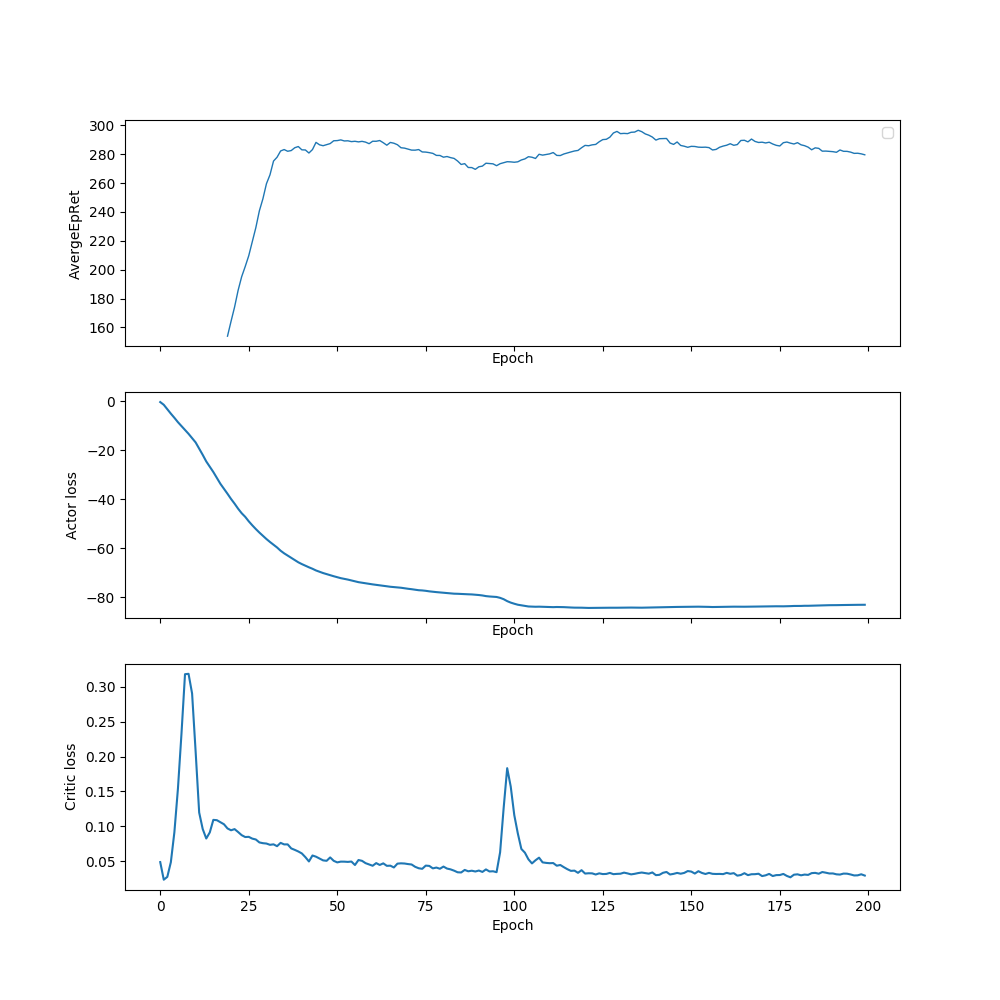

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


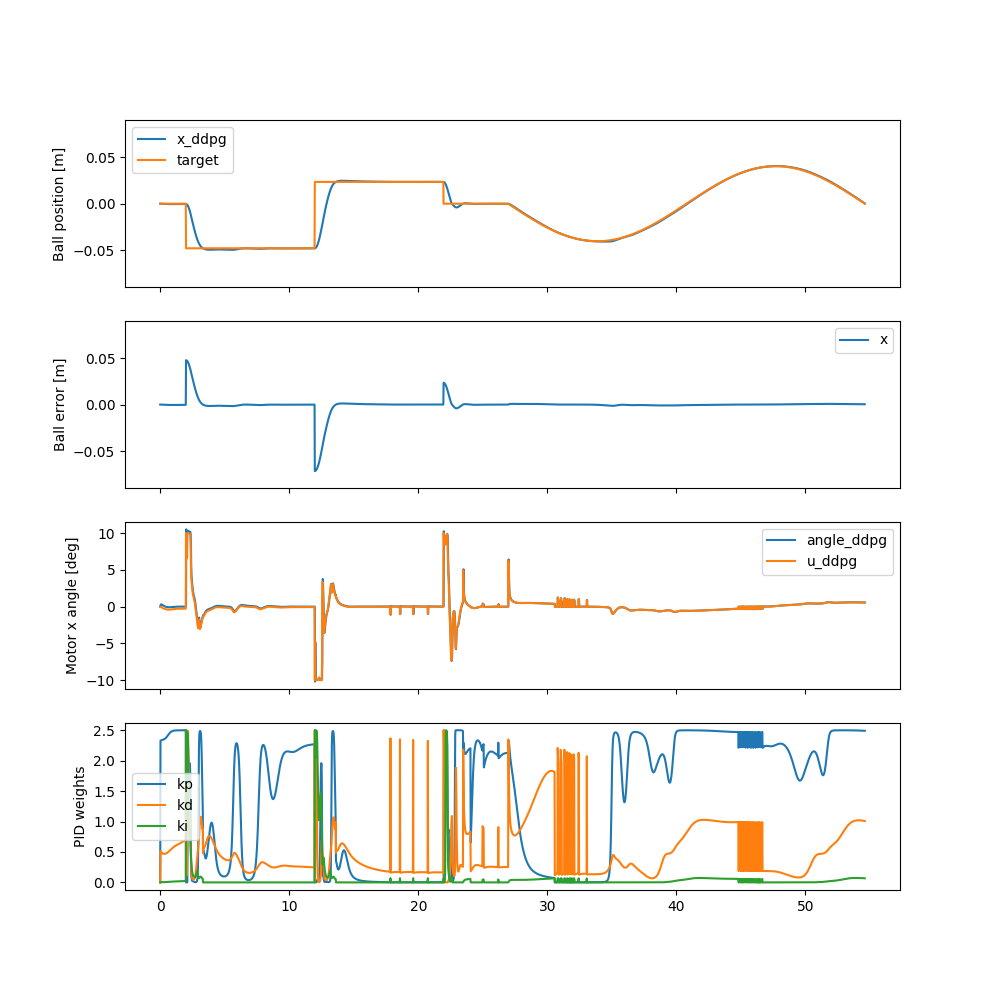

In [19]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[200]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50,25]_sigmoid_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            50,
            25
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3dc3df3cc0>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50,25]_sigmoid_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50,25]_sigmoid_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
                  

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |             206 |
|          StdEpRet |            84.2 |
|          MaxEpRet |             286 |
|          MinEpRet |            89.3 |
|  AverageTestEpRet |             159 |
|      StdTestEpRet |              75 |
|      MaxTestEpRet |             274 |
|      MinTestEpRet |              45 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            14.3 |
|          StdQVals |            3.89 |
|          MaxQVals |            20.8 |
|          MinQVals |           -7.05 |
|            LossPi |           -14.5 |
|             LossQ |          0.0922 |
|              Time |            62.4 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            81.7 |
|          StdEpRet |            27.3 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             185 |
|          StdEpRet |            29.3 |
|          MaxEpRet |             219 |
|          MinEpRet |             147 |
|  AverageTestEpRet |             252 |
|      StdTestEpRet |            36.7 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             183 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            32.7 |
|          StdQVals |            6.63 |
|          MaxQVals |            45.1 |
|          MinQVals |           -2.88 |
|            LossPi |             -33 |
|             LossQ |          0.0899 |
|              Time |             150 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             251 |
|          StdEpRet |            54.6 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             267 |
|          StdEpRet |            11.8 |
|          MaxEpRet |             282 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             271 |
|      StdTestEpRet |            21.4 |
|      MaxTestEpRet |             308 |
|      MinTestEpRet |             239 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |            50.5 |
|          StdQVals |            8.06 |
|          MaxQVals |            60.1 |
|          MinQVals |           0.526 |
|            LossPi |           -50.8 |
|             LossQ |          0.0843 |
|              Time |             239 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             242 |
|          StdEpRet |            17.9 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             262 |
|          StdEpRet |            20.1 |
|          MaxEpRet |             287 |
|          MinEpRet |             238 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            21.5 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             260 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |              61 |
|          StdQVals |             8.1 |
|          MaxQVals |            70.9 |
|          MinQVals |            10.1 |
|            LossPi |           -61.2 |
|             LossQ |          0.0591 |
|              Time |             330 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             288 |
|          StdEpRet |            27.9 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             273 |
|          StdEpRet |            7.09 |
|          MaxEpRet |             283 |
|          MinEpRet |             266 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            25.2 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |              68 |
|          StdQVals |            7.83 |
|          MaxQVals |            75.8 |
|          MinQVals |            9.96 |
|            LossPi |           -68.1 |
|             LossQ |          0.0481 |
|              Time |             417 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             272 |
|          StdEpRet |            5.57 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             266 |
|          StdEpRet |            18.4 |
|          MaxEpRet |             292 |
|          MinEpRet |             251 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |            20.1 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             254 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |            71.9 |
|          StdQVals |            7.68 |
|          MaxQVals |            78.6 |
|          MinQVals |            12.5 |
|            LossPi |           -72.1 |
|             LossQ |          0.0406 |
|              Time |             506 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             273 |
|          StdEpRet |            28.1 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             296 |
|          StdEpRet |            6.25 |
|          MaxEpRet |             302 |
|          MinEpRet |             287 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            20.5 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            73.9 |
|          StdQVals |             7.8 |
|          MaxQVals |            80.7 |
|          MinQVals |            16.2 |
|            LossPi |             -74 |
|             LossQ |           0.041 |
|              Time |             596 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             270 |
|          StdEpRet |            8.61 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             287 |
|          StdEpRet |              24 |
|          MaxEpRet |             321 |
|          MinEpRet |             268 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            28.1 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             242 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            76.1 |
|          StdQVals |            7.47 |
|          MaxQVals |            81.9 |
|          MinQVals |            19.7 |
|            LossPi |           -76.2 |
|             LossQ |          0.0379 |
|              Time |             683 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             295 |
|          StdEpRet |            1.87 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             266 |
|          StdEpRet |              35 |
|          MaxEpRet |             310 |
|          MinEpRet |             225 |
|  AverageTestEpRet |             307 |
|      StdTestEpRet |            23.3 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             241 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |              78 |
|          StdQVals |            6.71 |
|          MaxQVals |            82.8 |
|          MinQVals |            19.7 |
|            LossPi |             -78 |
|             LossQ |          0.0299 |
|              Time |             768 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             296 |
|          StdEpRet |            13.7 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             300 |
|          StdEpRet |            24.7 |
|          MaxEpRet |             334 |
|          MinEpRet |             277 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            23.7 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             259 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |            78.9 |
|          StdQVals |            6.81 |
|          MaxQVals |            83.6 |
|          MinQVals |            21.3 |
|            LossPi |           -78.9 |
|             LossQ |          0.0277 |
|              Time |             857 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             288 |
|          StdEpRet |            16.3 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             258 |
|          StdEpRet |            5.49 |
|          MaxEpRet |             266 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             294 |
|      StdTestEpRet |            29.4 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             255 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |            79.2 |
|          StdQVals |            6.99 |
|          MaxQVals |            84.6 |
|          MinQVals |            22.2 |
|            LossPi |           -79.2 |
|             LossQ |          0.0316 |
|              Time |             946 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             275 |
|          StdEpRet |            10.7 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             301 |
|          StdEpRet |            19.3 |
|          MaxEpRet |             329 |
|          MinEpRet |             286 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            26.7 |
|      MaxTestEpRet |             345 |
|      MinTestEpRet |             248 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |            79.7 |
|          StdQVals |            7.39 |
|          MaxQVals |            85.3 |
|          MinQVals |            29.7 |
|            LossPi |           -79.7 |
|             LossQ |          0.0278 |
|              Time |        1.04e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             273 |
|          StdEpRet |            27.2 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             309 |
|          StdEpRet |            19.8 |
|          MaxEpRet |             324 |
|          MinEpRet |             281 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            18.9 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             273 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |            80.2 |
|          StdQVals |            7.37 |
|          MaxQVals |            85.8 |
|          MinQVals |            25.7 |
|            LossPi |           -80.3 |
|             LossQ |           0.027 |
|              Time |        1.12e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |             307 |
|          StdEpRet |            16.7 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             283 |
|          StdEpRet |            27.3 |
|          MaxEpRet |             307 |
|          MinEpRet |             245 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            25.3 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            80.8 |
|          StdQVals |            7.33 |
|          MaxQVals |            86.3 |
|          MinQVals |              29 |
|            LossPi |           -80.8 |
|             LossQ |           0.025 |
|              Time |        1.21e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             268 |
|          StdEpRet |            19.3 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             304 |
|          StdEpRet |            36.4 |
|          MaxEpRet |             336 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            22.7 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             249 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |            81.2 |
|          StdQVals |            7.31 |
|          MaxQVals |            87.1 |
|          MinQVals |              25 |
|            LossPi |           -81.3 |
|             LossQ |          0.0312 |
|              Time |         1.3e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             271 |
|          StdEpRet |            9.01 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             274 |
|          StdEpRet |            17.2 |
|          MaxEpRet |             297 |
|          MinEpRet |             256 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            19.3 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            81.5 |
|          StdQVals |            7.21 |
|          MaxQVals |            87.3 |
|          MinQVals |            25.3 |
|            LossPi |           -81.5 |
|             LossQ |           0.034 |
|              Time |        1.39e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             307 |
|          StdEpRet |            24.7 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             282 |
|          StdEpRet |            8.91 |
|          MaxEpRet |             291 |
|          MinEpRet |             270 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |              22 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             272 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            81.6 |
|          StdQVals |            7.34 |
|          MaxQVals |            88.1 |
|          MinQVals |              23 |
|            LossPi |           -81.7 |
|             LossQ |          0.0344 |
|              Time |        1.48e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             317 |
|          StdEpRet |            16.5 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             280 |
|          StdEpRet |            18.3 |
|          MaxEpRet |             299 |
|          MinEpRet |             255 |
|  AverageTestEpRet |             320 |
|      StdTestEpRet |            19.9 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             280 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |            82.5 |
|          StdQVals |            7.31 |
|          MaxQVals |            88.8 |
|          MinQVals |            22.9 |
|            LossPi |           -82.5 |
|             LossQ |           0.031 |
|              Time |        1.57e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             296 |
|          StdEpRet |            32.3 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             289 |
|          StdEpRet |            22.5 |
|          MaxEpRet |             319 |
|          MinEpRet |             266 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |            26.5 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |            82.5 |
|          StdQVals |            7.16 |
|          MaxQVals |            88.8 |
|          MinQVals |            22.6 |
|            LossPi |           -82.5 |
|             LossQ |            0.03 |
|              Time |        1.65e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             310 |
|          StdEpRet |              18 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             301 |
|          StdEpRet |            37.7 |
|          MaxEpRet |             332 |
|          MinEpRet |             248 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |              25 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |            82.4 |
|          StdQVals |            7.31 |
|          MaxQVals |            88.8 |
|          MinQVals |            22.7 |
|            LossPi |           -82.4 |
|             LossQ |          0.0326 |
|              Time |        1.74e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             273 |
|          StdEpRet |            7.53 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.19788465870360877


<IPython.core.display.Javascript object>


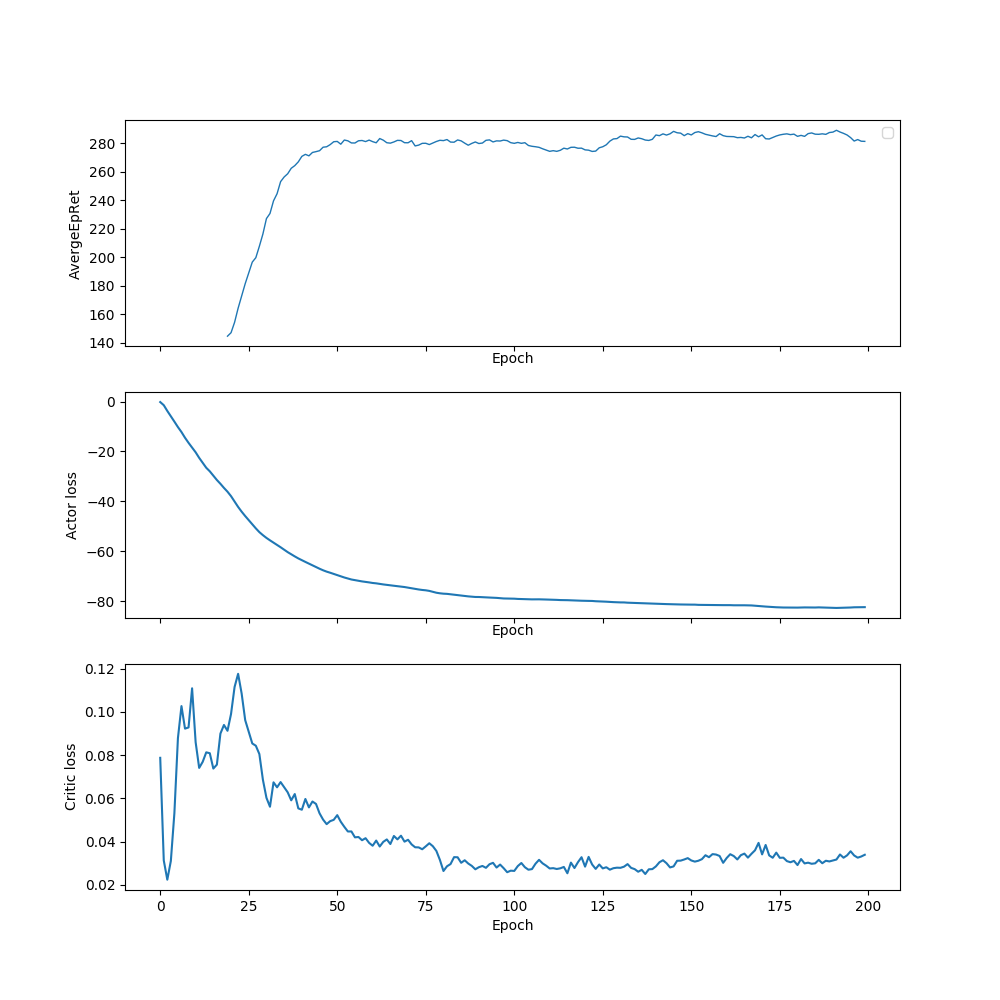

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


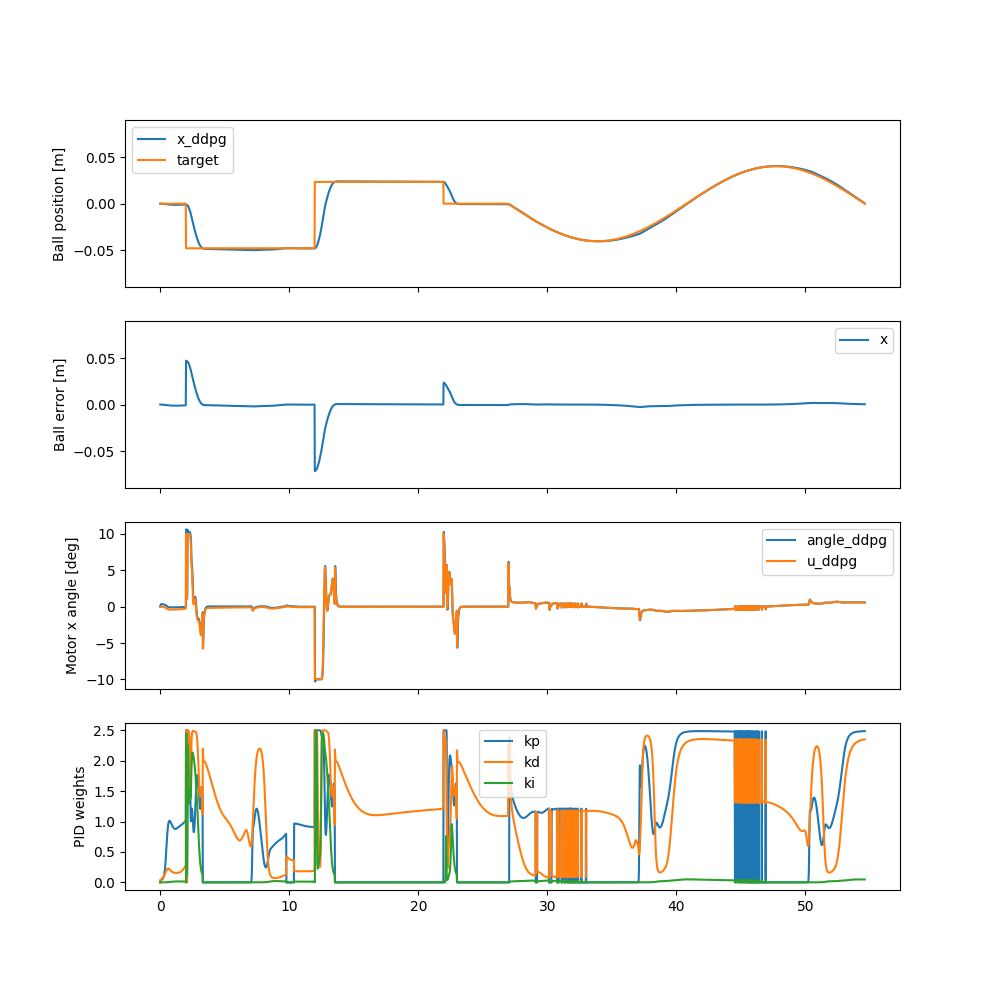

In [20]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50,25]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50,25]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50,50]_sigmoid_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            50,
            50
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3db00df208>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50,50]_sigmoid_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[50,50]_sigmoid_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
                  

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            80.3 |
|          StdEpRet |              15 |
|          MaxEpRet |            96.3 |
|          MinEpRet |            60.2 |
|  AverageTestEpRet |             138 |
|      StdTestEpRet |            86.3 |
|      MaxTestEpRet |             293 |
|      MinTestEpRet |            41.2 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            15.8 |
|          StdQVals |            4.94 |
|          MaxQVals |            26.8 |
|          MinQVals |            -3.7 |
|            LossPi |             -16 |
|             LossQ |          0.0695 |
|              Time |            69.2 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            90.3 |
|          StdEpRet |            7.68 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             288 |
|          StdEpRet |            32.1 |
|          MaxEpRet |             328 |
|          MinEpRet |             249 |
|  AverageTestEpRet |             275 |
|      StdTestEpRet |            26.4 |
|      MaxTestEpRet |             328 |
|      MinTestEpRet |             243 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            34.3 |
|          StdQVals |             9.5 |
|          MaxQVals |              49 |
|          MinQVals |          -0.796 |
|            LossPi |           -34.7 |
|             LossQ |          0.0761 |
|              Time |             159 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             273 |
|          StdEpRet |            32.3 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             283 |
|          StdEpRet |            44.2 |
|          MaxEpRet |             320 |
|          MinEpRet |             221 |
|  AverageTestEpRet |             297 |
|      StdTestEpRet |            23.5 |
|      MaxTestEpRet |             331 |
|      MinTestEpRet |             248 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |              52 |
|          StdQVals |            10.1 |
|          MaxQVals |            64.7 |
|          MinQVals |           0.396 |
|            LossPi |           -52.3 |
|             LossQ |          0.0886 |
|              Time |             279 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             268 |
|          StdEpRet |            44.1 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             282 |
|          StdEpRet |            14.1 |
|          MaxEpRet |             293 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            18.5 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             263 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |            62.4 |
|          StdQVals |            9.63 |
|          MaxQVals |            73.3 |
|          MinQVals |            14.1 |
|            LossPi |           -62.6 |
|             LossQ |           0.077 |
|              Time |             423 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             260 |
|          StdEpRet |            20.9 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             286 |
|          StdEpRet |             6.8 |
|          MaxEpRet |             293 |
|          MinEpRet |             276 |
|  AverageTestEpRet |             307 |
|      StdTestEpRet |            21.3 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             266 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |            68.6 |
|          StdQVals |            9.26 |
|          MaxQVals |            78.1 |
|          MinQVals |            17.8 |
|            LossPi |           -68.8 |
|             LossQ |          0.0433 |
|              Time |             587 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             285 |
|          StdEpRet |            27.4 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             282 |
|          StdEpRet |            21.5 |
|          MaxEpRet |             312 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            25.5 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             259 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |            72.1 |
|          StdQVals |            9.08 |
|          MaxQVals |            80.8 |
|          MinQVals |            18.5 |
|            LossPi |           -72.2 |
|             LossQ |           0.038 |
|              Time |             748 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             262 |
|          StdEpRet |              13 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             291 |
|          StdEpRet |            28.4 |
|          MaxEpRet |             329 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |              26 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             241 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            74.2 |
|          StdQVals |             8.9 |
|          MaxQVals |            82.2 |
|          MinQVals |            20.2 |
|            LossPi |           -74.3 |
|             LossQ |          0.0411 |
|              Time |             920 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             288 |
|          StdEpRet |            14.9 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             288 |
|          StdEpRet |            33.4 |
|          MaxEpRet |             322 |
|          MinEpRet |             242 |
|  AverageTestEpRet |             287 |
|      StdTestEpRet |            26.5 |
|      MaxTestEpRet |             326 |
|      MinTestEpRet |             235 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            76.3 |
|          StdQVals |            8.58 |
|          MaxQVals |            83.2 |
|          MinQVals |            22.8 |
|            LossPi |           -76.3 |
|             LossQ |           0.034 |
|              Time |         1.1e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             280 |
|          StdEpRet |            13.9 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             299 |
|          StdEpRet |            11.4 |
|          MaxEpRet |             315 |
|          MinEpRet |             288 |
|  AverageTestEpRet |             314 |
|      StdTestEpRet |            21.9 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |              78 |
|          StdQVals |            7.34 |
|          MaxQVals |              84 |
|          MinQVals |            23.3 |
|            LossPi |             -78 |
|             LossQ |          0.0317 |
|              Time |        1.61e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             261 |
|          StdEpRet |            20.5 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             297 |
|          StdEpRet |            6.04 |
|          MaxEpRet |             303 |
|          MinEpRet |             288 |
|  AverageTestEpRet |             312 |
|      StdTestEpRet |            26.2 |
|      MaxTestEpRet |             347 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |            78.6 |
|          StdQVals |            7.15 |
|          MaxQVals |            84.7 |
|          MinQVals |            24.6 |
|            LossPi |           -78.6 |
|             LossQ |          0.0334 |
|              Time |        2.04e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             284 |
|          StdEpRet |            33.6 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             275 |
|          StdEpRet |            17.2 |
|          MaxEpRet |             295 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             309 |
|      StdTestEpRet |            23.3 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             274 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |            79.1 |
|          StdQVals |             7.2 |
|          MaxQVals |            85.8 |
|          MinQVals |              21 |
|            LossPi |           -79.1 |
|             LossQ |          0.0366 |
|              Time |        2.71e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             310 |
|          StdEpRet |            31.2 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             290 |
|          StdEpRet |            31.8 |
|          MaxEpRet |             331 |
|          MinEpRet |             254 |
|  AverageTestEpRet |             168 |
|      StdTestEpRet |            96.6 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |              81 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |            79.5 |
|          StdQVals |             7.1 |
|          MaxQVals |            86.5 |
|          MinQVals |            23.2 |
|            LossPi |           -79.5 |
|             LossQ |           0.043 |
|              Time |        3.46e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             261 |
|          StdEpRet |            51.1 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             268 |
|          StdEpRet |            5.91 |
|          MaxEpRet |             275 |
|          MinEpRet |             260 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            19.8 |
|      MaxTestEpRet |             345 |
|      MinTestEpRet |             274 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |            79.9 |
|          StdQVals |            6.77 |
|          MaxQVals |            86.8 |
|          MinQVals |            24.3 |
|            LossPi |           -79.9 |
|             LossQ |          0.0359 |
|              Time |        4.04e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |             273 |
|          StdEpRet |            21.6 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             293 |
|          StdEpRet |            27.2 |
|          MaxEpRet |             326 |
|          MinEpRet |             259 |
|  AverageTestEpRet |             312 |
|      StdTestEpRet |            21.4 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             267 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            80.6 |
|          StdQVals |            6.76 |
|          MaxQVals |              87 |
|          MinQVals |            22.5 |
|            LossPi |           -80.7 |
|             LossQ |          0.0342 |
|              Time |        4.67e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             264 |
|          StdEpRet |              14 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             291 |
|          StdEpRet |            25.7 |
|          MaxEpRet |             327 |
|          MinEpRet |             268 |
|  AverageTestEpRet |             312 |
|      StdTestEpRet |            26.1 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             241 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |            80.7 |
|          StdQVals |            7.15 |
|          MaxQVals |            87.3 |
|          MinQVals |            21.6 |
|            LossPi |           -80.7 |
|             LossQ |           0.036 |
|              Time |        5.23e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             290 |
|          StdEpRet |            5.32 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             322 |
|          StdEpRet |            17.8 |
|          MaxEpRet |             344 |
|          MinEpRet |             301 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            27.2 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             246 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            81.3 |
|          StdQVals |            7.12 |
|          MaxQVals |            87.6 |
|          MinQVals |            20.8 |
|            LossPi |           -81.4 |
|             LossQ |          0.0341 |
|              Time |         5.8e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             284 |
|          StdEpRet |            19.3 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             283 |
|          StdEpRet |            13.3 |
|          MaxEpRet |             295 |
|          MinEpRet |             264 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            24.2 |
|      MaxTestEpRet |             331 |
|      MinTestEpRet |             258 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            81.9 |
|          StdQVals |            6.86 |
|          MaxQVals |            87.4 |
|          MinQVals |            22.2 |
|            LossPi |           -81.9 |
|             LossQ |          0.0306 |
|              Time |        6.33e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             317 |
|          StdEpRet |            21.4 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             294 |
|          StdEpRet |            19.8 |
|          MaxEpRet |             318 |
|          MinEpRet |             269 |
|  AverageTestEpRet |             307 |
|      StdTestEpRet |            25.3 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             249 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |            82.1 |
|          StdQVals |            6.88 |
|          MaxQVals |            87.3 |
|          MinQVals |            21.2 |
|            LossPi |           -82.1 |
|             LossQ |          0.0335 |
|              Time |        6.85e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             281 |
|          StdEpRet |            6.39 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             308 |
|          StdEpRet |            10.6 |
|          MaxEpRet |             323 |
|          MinEpRet |             298 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            20.3 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             271 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |            82.3 |
|          StdQVals |            6.86 |
|          MaxQVals |            87.7 |
|          MinQVals |            20.4 |
|            LossPi |           -82.3 |
|             LossQ |          0.0306 |
|              Time |        7.39e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             315 |
|          StdEpRet |            29.9 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             274 |
|          StdEpRet |            17.1 |
|          MaxEpRet |             296 |
|          MinEpRet |             255 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            21.6 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             258 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |            82.3 |
|          StdQVals |            7.17 |
|          MaxQVals |            88.2 |
|          MinQVals |              22 |
|            LossPi |           -82.4 |
|             LossQ |          0.0303 |
|              Time |        8.01e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             285 |
|          StdEpRet |            27.1 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.1999694596746847


<IPython.core.display.Javascript object>


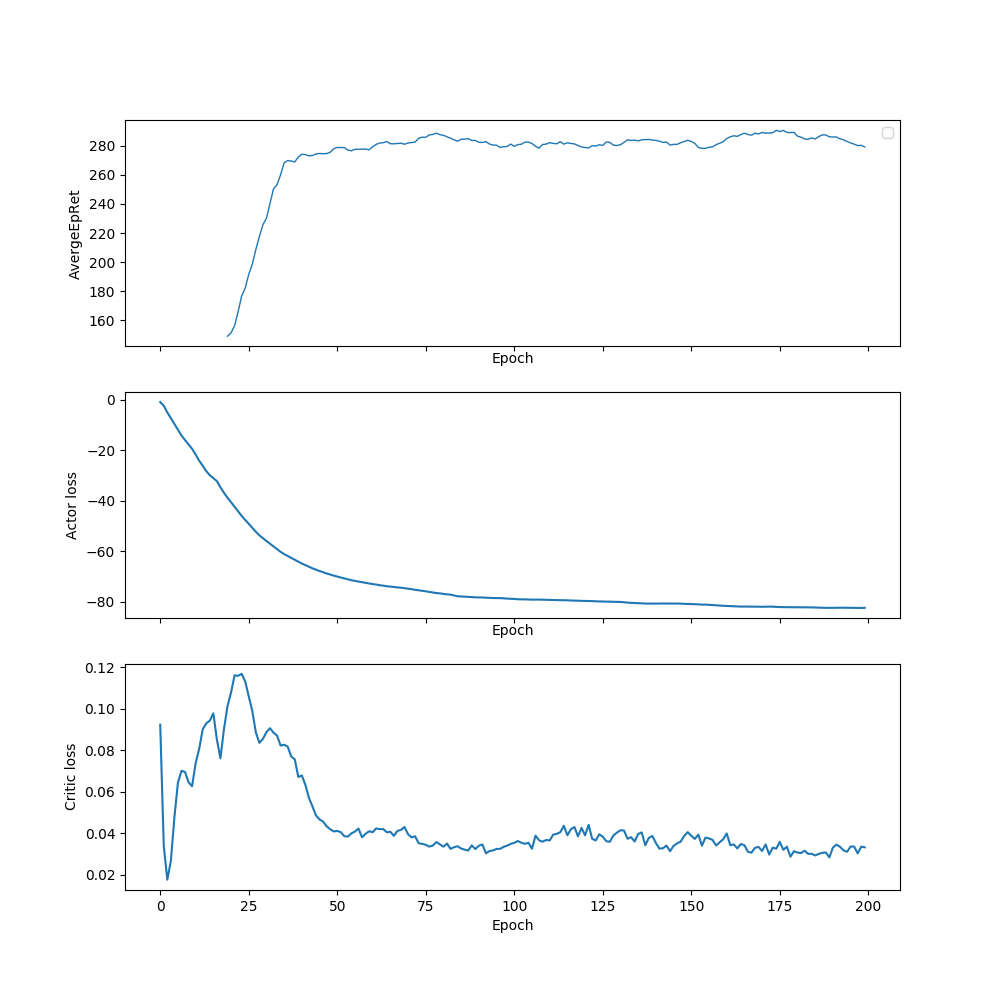

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


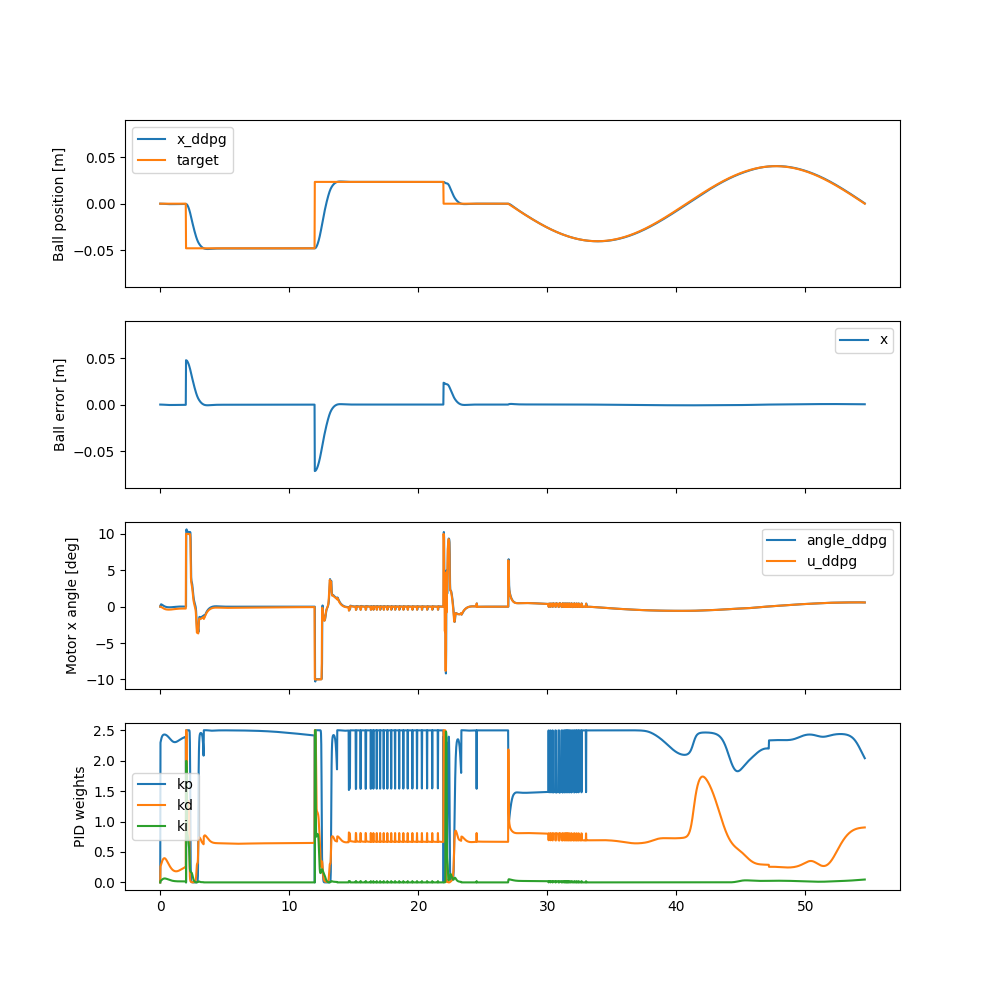

In [21]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50,50]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50,50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100,50]_sigmoid_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            100,
            50
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3db023b390>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100,50]_sigmoid_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100,50]_sigmoid_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
              

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |             125 |
|          StdEpRet |            47.5 |
|          MaxEpRet |             190 |
|          MinEpRet |            77.5 |
|  AverageTestEpRet |             163 |
|      StdTestEpRet |            85.8 |
|      MaxTestEpRet |             301 |
|      MinTestEpRet |            41.3 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            13.1 |
|          StdQVals |            4.35 |
|          MaxQVals |            22.6 |
|          MinQVals |           -7.24 |
|            LossPi |           -13.3 |
|             LossQ |          0.0552 |
|              Time |             455 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            57.5 |
|          StdEpRet |           0.262 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |            99.6 |
|          StdEpRet |             116 |
|          MaxEpRet |             263 |
|          MinEpRet |            4.84 |
|  AverageTestEpRet |             156 |
|      StdTestEpRet |            89.9 |
|      MaxTestEpRet |             320 |
|      MinTestEpRet |            45.5 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            30.4 |
|          StdQVals |            10.4 |
|          MaxQVals |              46 |
|          MinQVals |           -11.7 |
|            LossPi |           -30.6 |
|             LossQ |          0.0857 |
|              Time |        1.08e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             144 |
|          StdEpRet |             132 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             290 |
|          StdEpRet |            16.8 |
|          MaxEpRet |             304 |
|          MinEpRet |             266 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |              25 |
|      MaxTestEpRet |             344 |
|      MinTestEpRet |             252 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |            48.4 |
|          StdQVals |            12.8 |
|          MaxQVals |            62.4 |
|          MinQVals |           -7.22 |
|            LossPi |           -48.7 |
|             LossQ |          0.0947 |
|              Time |        1.56e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             288 |
|          StdEpRet |            8.24 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             296 |
|          StdEpRet |            28.5 |
|          MaxEpRet |             331 |
|          MinEpRet |             261 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            20.5 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             255 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |              61 |
|          StdQVals |            12.4 |
|          MaxQVals |            74.4 |
|          MinQVals |            2.82 |
|            LossPi |           -61.2 |
|             LossQ |          0.0731 |
|              Time |        2.03e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             289 |
|          StdEpRet |            32.2 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             279 |
|          StdEpRet |            31.2 |
|          MaxEpRet |             313 |
|          MinEpRet |             238 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |            22.4 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |            68.6 |
|          StdQVals |            11.3 |
|          MaxQVals |            80.4 |
|          MinQVals |            14.7 |
|            LossPi |           -68.7 |
|             LossQ |          0.0459 |
|              Time |        2.41e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             329 |
|          StdEpRet |            1.48 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             304 |
|          StdEpRet |            24.5 |
|          MaxEpRet |             338 |
|          MinEpRet |             284 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            25.8 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |            72.3 |
|          StdQVals |              11 |
|          MaxQVals |            82.7 |
|          MinQVals |            16.8 |
|            LossPi |           -72.4 |
|             LossQ |          0.0455 |
|              Time |        2.58e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             262 |
|          StdEpRet |            12.8 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             273 |
|          StdEpRet |            31.7 |
|          MaxEpRet |             310 |
|          MinEpRet |             233 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |            23.3 |
|      MaxTestEpRet |             349 |
|      MinTestEpRet |             253 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            74.9 |
|          StdQVals |            10.4 |
|          MaxQVals |            84.4 |
|          MinQVals |              19 |
|            LossPi |             -75 |
|             LossQ |          0.0419 |
|              Time |        2.72e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             280 |
|          StdEpRet |            38.9 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             292 |
|          StdEpRet |            24.4 |
|          MaxEpRet |             324 |
|          MinEpRet |             265 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            23.7 |
|      MaxTestEpRet |             345 |
|      MinTestEpRet |             259 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            76.8 |
|          StdQVals |            10.1 |
|          MaxQVals |            85.6 |
|          MinQVals |            21.6 |
|            LossPi |           -76.9 |
|             LossQ |          0.0416 |
|              Time |        2.88e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             282 |
|          StdEpRet |            11.2 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             293 |
|          StdEpRet |            8.13 |
|          MaxEpRet |             300 |
|          MinEpRet |             282 |
|  AverageTestEpRet |             307 |
|      StdTestEpRet |            20.5 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |            79.2 |
|          StdQVals |            7.35 |
|          MaxQVals |              87 |
|          MinQVals |            25.1 |
|            LossPi |           -79.3 |
|             LossQ |          0.0408 |
|              Time |        3.06e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             259 |
|          StdEpRet |            10.9 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             317 |
|          StdEpRet |            23.6 |
|          MaxEpRet |             341 |
|          MinEpRet |             285 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            25.1 |
|      MaxTestEpRet |             345 |
|      MinTestEpRet |             258 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |              80 |
|          StdQVals |            7.07 |
|          MaxQVals |            87.6 |
|          MinQVals |            27.7 |
|            LossPi |           -80.1 |
|             LossQ |          0.0429 |
|              Time |        3.18e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             274 |
|          StdEpRet |            10.1 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             280 |
|          StdEpRet |              12 |
|          MaxEpRet |             290 |
|          MinEpRet |             263 |
|  AverageTestEpRet |             314 |
|      StdTestEpRet |            18.8 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |             274 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |            80.5 |
|          StdQVals |            7.18 |
|          MaxQVals |            88.1 |
|          MinQVals |            27.2 |
|            LossPi |           -80.5 |
|             LossQ |          0.0361 |
|              Time |        3.31e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             251 |
|          StdEpRet |             8.8 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             257 |
|          StdEpRet |            12.8 |
|          MaxEpRet |             268 |
|          MinEpRet |             239 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            23.6 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |            80.9 |
|          StdQVals |            7.46 |
|          MaxQVals |            88.4 |
|          MinQVals |            25.7 |
|            LossPi |             -81 |
|             LossQ |          0.0317 |
|              Time |        3.42e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             289 |
|          StdEpRet |            11.5 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             289 |
|          StdEpRet |            8.82 |
|          MaxEpRet |             300 |
|          MinEpRet |             279 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            22.2 |
|      MaxTestEpRet |             345 |
|      MinTestEpRet |             266 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |            81.6 |
|          StdQVals |            7.11 |
|          MaxQVals |            88.5 |
|          MinQVals |            26.4 |
|            LossPi |           -81.6 |
|             LossQ |          0.0309 |
|              Time |        3.54e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |             242 |
|          StdEpRet |            2.21 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             313 |
|          StdEpRet |            12.1 |
|          MaxEpRet |             324 |
|          MinEpRet |             296 |
|  AverageTestEpRet |             313 |
|      StdTestEpRet |            28.7 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             252 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            81.9 |
|          StdQVals |            7.17 |
|          MaxQVals |            88.6 |
|          MinQVals |            22.5 |
|            LossPi |             -82 |
|             LossQ |          0.0302 |
|              Time |        3.64e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             311 |
|          StdEpRet |            32.2 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             282 |
|          StdEpRet |            12.1 |
|          MaxEpRet |             294 |
|          MinEpRet |             266 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            26.8 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |            82.1 |
|          StdQVals |            7.06 |
|          MaxQVals |            88.5 |
|          MinQVals |            24.7 |
|            LossPi |           -82.2 |
|             LossQ |          0.0303 |
|              Time |        3.75e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             309 |
|          StdEpRet |            4.29 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             271 |
|          StdEpRet |            17.9 |
|          MaxEpRet |             287 |
|          MinEpRet |             246 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            30.7 |
|      MaxTestEpRet |             348 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            82.6 |
|          StdQVals |            6.84 |
|          MaxQVals |            88.5 |
|          MinQVals |            25.4 |
|            LossPi |           -82.7 |
|             LossQ |          0.0344 |
|              Time |        3.85e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             275 |
|          StdEpRet |            18.2 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             274 |
|          StdEpRet |            22.2 |
|          MaxEpRet |             292 |
|          MinEpRet |             243 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            25.5 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            82.8 |
|          StdQVals |            6.96 |
|          MaxQVals |            88.3 |
|          MinQVals |            25.8 |
|            LossPi |           -82.8 |
|             LossQ |           0.032 |
|              Time |        3.96e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             266 |
|          StdEpRet |            24.8 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             298 |
|          StdEpRet |              21 |
|          MaxEpRet |             324 |
|          MinEpRet |             273 |
|  AverageTestEpRet |             307 |
|      StdTestEpRet |            21.6 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             274 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |              83 |
|          StdQVals |            6.86 |
|          MaxQVals |            88.3 |
|          MinQVals |              23 |
|            LossPi |           -83.1 |
|             LossQ |          0.0346 |
|              Time |        4.07e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             286 |
|          StdEpRet |            23.4 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             298 |
|          StdEpRet |            17.9 |
|          MaxEpRet |             322 |
|          MinEpRet |             280 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            22.8 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             263 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |              83 |
|          StdQVals |            6.89 |
|          MaxQVals |            88.3 |
|          MinQVals |            22.2 |
|            LossPi |           -83.1 |
|             LossQ |          0.0334 |
|              Time |        4.18e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             307 |
|          StdEpRet |              23 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             257 |
|          StdEpRet |            14.5 |
|          MaxEpRet |             274 |
|          MinEpRet |             238 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            24.3 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |              83 |
|          StdQVals |            6.93 |
|          MaxQVals |            88.3 |
|          MinQVals |            22.6 |
|            LossPi |             -83 |
|             LossQ |          0.0328 |
|              Time |        4.28e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             261 |
|          StdEpRet |            19.9 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.19703997157404943


<IPython.core.display.Javascript object>


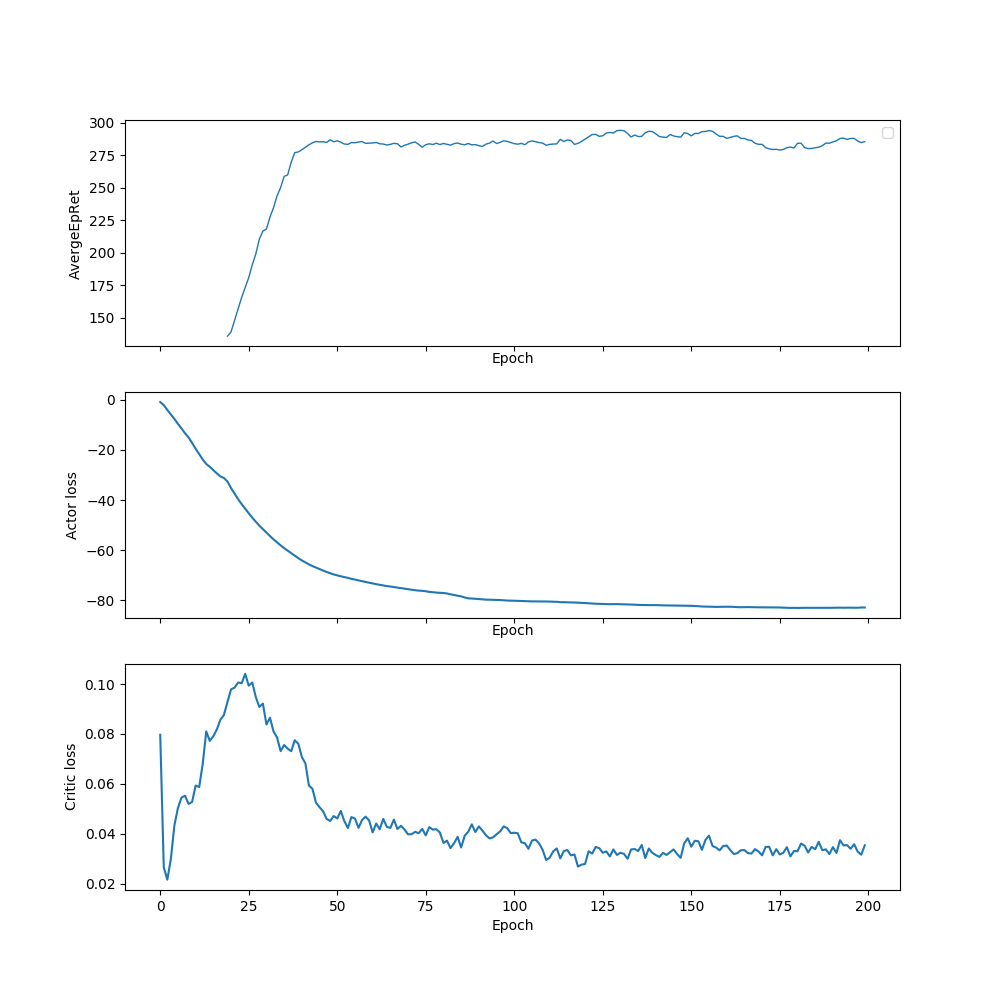

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


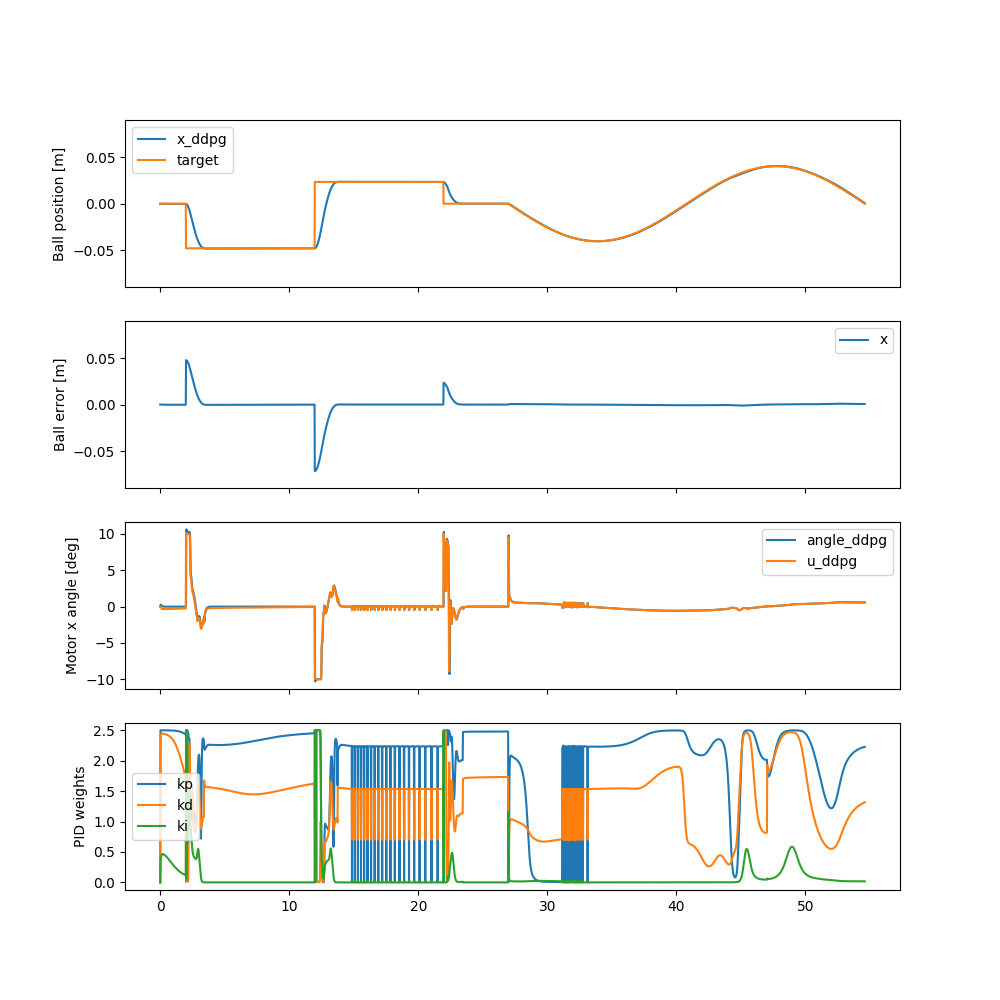

In [22]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100,50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

Logging data to src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100,100]_sigmoid_75000/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            100,
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"PidActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	200,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f3dab9f1c88>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100,100]_sigmoid_75000",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/dyn_pid_controller_1d/exploratory_penality/lep_0.6_[100,100]_sigmoid_75000/progress.txt' mode='w' encoding='UTF-8'>":	{
          

---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |             167 |
|          StdEpRet |             112 |
|          MaxEpRet |             322 |
|          MinEpRet |            63.7 |
|  AverageTestEpRet |             146 |
|      StdTestEpRet |            85.5 |
|      MaxTestEpRet |             322 |
|      MinTestEpRet |            45.8 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         8.8e+03 |
|      AverageQVals |            12.5 |
|          StdQVals |            2.65 |
|          MaxQVals |            16.5 |
|          MinQVals |           -4.88 |
|            LossPi |           -12.7 |
|             LossQ |          0.0351 |
|              Time |              78 |
---------------------------------------
---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |            65.5 |
|          StdEpRet |               9 |


---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             227 |
|          StdEpRet |            10.3 |
|          MaxEpRet |             239 |
|          MinEpRet |             214 |
|  AverageTestEpRet |             260 |
|      StdTestEpRet |              26 |
|      MaxTestEpRet |             298 |
|      MinTestEpRet |             201 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.98e+04 |
|      AverageQVals |            31.1 |
|          StdQVals |            6.97 |
|          MaxQVals |            45.4 |
|          MinQVals |           -6.32 |
|            LossPi |           -31.3 |
|             LossQ |          0.0812 |
|              Time |             186 |
---------------------------------------
---------------------------------------
|             Epoch |              19 |
|      AverageEpRet |             235 |
|          StdEpRet |            42.5 |


---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             267 |
|          StdEpRet |            5.67 |
|          MaxEpRet |             271 |
|          MinEpRet |             259 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            18.6 |
|      MaxTestEpRet |             326 |
|      MinTestEpRet |             251 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        3.08e+04 |
|      AverageQVals |            50.8 |
|          StdQVals |            8.51 |
|          MaxQVals |            63.4 |
|          MinQVals |            7.15 |
|            LossPi |             -51 |
|             LossQ |          0.0717 |
|              Time |             302 |
---------------------------------------
---------------------------------------
|             Epoch |              29 |
|      AverageEpRet |             284 |
|          StdEpRet |            42.8 |


---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             272 |
|          StdEpRet |             9.1 |
|          MaxEpRet |             284 |
|          MinEpRet |             264 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            24.2 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             256 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        4.18e+04 |
|      AverageQVals |            62.9 |
|          StdQVals |            8.72 |
|          MaxQVals |            73.6 |
|          MinQVals |            10.8 |
|            LossPi |           -63.1 |
|             LossQ |          0.0403 |
|              Time |             420 |
---------------------------------------
---------------------------------------
|             Epoch |              39 |
|      AverageEpRet |             272 |
|          StdEpRet |            30.6 |


---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             272 |
|          StdEpRet |            68.9 |
|          MaxEpRet |             320 |
|          MinEpRet |             174 |
|  AverageTestEpRet |             257 |
|      StdTestEpRet |            99.9 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |            37.2 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        5.28e+04 |
|      AverageQVals |            69.1 |
|          StdQVals |            8.45 |
|          MaxQVals |            79.3 |
|          MinQVals |            21.6 |
|            LossPi |           -69.3 |
|             LossQ |          0.0323 |
|              Time |             537 |
---------------------------------------
---------------------------------------
|             Epoch |              49 |
|      AverageEpRet |             293 |
|          StdEpRet |            2.68 |


---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             291 |
|          StdEpRet |            16.6 |
|          MaxEpRet |             313 |
|          MinEpRet |             273 |
|  AverageTestEpRet |             302 |
|      StdTestEpRet |              33 |
|      MaxTestEpRet |             339 |
|      MinTestEpRet |             238 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.38e+04 |
|      AverageQVals |            72.8 |
|          StdQVals |            8.49 |
|          MaxQVals |            82.6 |
|          MinQVals |            19.2 |
|            LossPi |           -72.9 |
|             LossQ |           0.036 |
|              Time |             651 |
---------------------------------------
---------------------------------------
|             Epoch |              59 |
|      AverageEpRet |             314 |
|          StdEpRet |              16 |


---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             279 |
|          StdEpRet |            30.5 |
|          MaxEpRet |             321 |
|          MinEpRet |             252 |
|  AverageTestEpRet |             311 |
|      StdTestEpRet |            23.2 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.48e+04 |
|      AverageQVals |            75.1 |
|          StdQVals |            8.13 |
|          MaxQVals |            84.7 |
|          MinQVals |            23.2 |
|            LossPi |           -75.3 |
|             LossQ |          0.0322 |
|              Time |             768 |
---------------------------------------
---------------------------------------
|             Epoch |              69 |
|      AverageEpRet |             290 |
|          StdEpRet |            10.6 |


---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             276 |
|          StdEpRet |            16.2 |
|          MaxEpRet |             292 |
|          MinEpRet |             254 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |            24.9 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             254 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.58e+04 |
|      AverageQVals |            77.5 |
|          StdQVals |            7.74 |
|          MaxQVals |            85.6 |
|          MinQVals |            23.8 |
|            LossPi |           -77.6 |
|             LossQ |          0.0322 |
|              Time |             888 |
---------------------------------------
---------------------------------------
|             Epoch |              79 |
|      AverageEpRet |             288 |
|          StdEpRet |            11.7 |


---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             286 |
|          StdEpRet |            27.6 |
|          MaxEpRet |             323 |
|          MinEpRet |             257 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |              22 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             256 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.68e+04 |
|      AverageQVals |              79 |
|          StdQVals |             7.1 |
|          MaxQVals |            86.1 |
|          MinQVals |            24.5 |
|            LossPi |             -79 |
|             LossQ |          0.0326 |
|              Time |           1e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              89 |
|      AverageEpRet |             269 |
|          StdEpRet |            22.9 |


---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             285 |
|          StdEpRet |            19.4 |
|          MaxEpRet |             312 |
|          MinEpRet |             268 |
|  AverageTestEpRet |             317 |
|      StdTestEpRet |            22.2 |
|      MaxTestEpRet |             346 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.08e+05 |
|      AverageQVals |            79.7 |
|          StdQVals |             7.4 |
|          MaxQVals |            86.6 |
|          MinQVals |            24.1 |
|            LossPi |           -79.7 |
|             LossQ |          0.0325 |
|              Time |        1.12e+03 |
---------------------------------------
---------------------------------------
|             Epoch |              99 |
|      AverageEpRet |             293 |
|          StdEpRet |            6.04 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             279 |
|          StdEpRet |            35.9 |
|          MaxEpRet |             325 |
|          MinEpRet |             238 |
|  AverageTestEpRet |             291 |
|      StdTestEpRet |            30.1 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             192 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.19e+05 |
|      AverageQVals |            80.8 |
|          StdQVals |            7.11 |
|          MaxQVals |            86.8 |
|          MinQVals |            23.9 |
|            LossPi |           -80.9 |
|             LossQ |          0.0385 |
|              Time |        1.24e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |             269 |
|          StdEpRet |            0.27 |


---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             269 |
|          StdEpRet |            18.9 |
|          MaxEpRet |             287 |
|          MinEpRet |             243 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            23.4 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             261 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.3e+05 |
|      AverageQVals |            81.5 |
|          StdQVals |            7.15 |
|          MaxQVals |            86.9 |
|          MinQVals |            24.7 |
|            LossPi |           -81.6 |
|             LossQ |          0.0379 |
|              Time |        1.35e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |             321 |
|          StdEpRet |            17.4 |


---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             289 |
|          StdEpRet |            10.2 |
|          MaxEpRet |             301 |
|          MinEpRet |             276 |
|  AverageTestEpRet |             313 |
|      StdTestEpRet |              22 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             259 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.41e+05 |
|      AverageQVals |              82 |
|          StdQVals |            7.28 |
|          MaxQVals |            87.4 |
|          MinQVals |            25.6 |
|            LossPi |             -82 |
|             LossQ |          0.0396 |
|              Time |        1.47e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             129 |
|      AverageEpRet |             298 |
|          StdEpRet |            17.9 |


---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             285 |
|          StdEpRet |            35.5 |
|          MaxEpRet |             334 |
|          MinEpRet |             252 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |              25 |
|      MaxTestEpRet |             343 |
|      MinTestEpRet |             260 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.52e+05 |
|      AverageQVals |            82.4 |
|          StdQVals |            7.13 |
|          MaxQVals |            87.6 |
|          MinQVals |            27.5 |
|            LossPi |           -82.5 |
|             LossQ |          0.0342 |
|              Time |        1.59e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             139 |
|      AverageEpRet |             282 |
|          StdEpRet |            26.5 |


---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             281 |
|          StdEpRet |            15.5 |
|          MaxEpRet |             292 |
|          MinEpRet |             259 |
|  AverageTestEpRet |             309 |
|      StdTestEpRet |            23.4 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |             259 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.63e+05 |
|      AverageQVals |            82.7 |
|          StdQVals |            7.24 |
|          MaxQVals |            87.9 |
|          MinQVals |            28.3 |
|            LossPi |           -82.7 |
|             LossQ |          0.0329 |
|              Time |        1.71e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             149 |
|      AverageEpRet |             292 |
|          StdEpRet |            15.3 |


---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             293 |
|          StdEpRet |            37.5 |
|          MaxEpRet |             324 |
|          MinEpRet |             240 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |              21 |
|      MaxTestEpRet |             340 |
|      MinTestEpRet |             268 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.74e+05 |
|      AverageQVals |            82.9 |
|          StdQVals |            7.41 |
|          MaxQVals |            88.1 |
|          MinQVals |            25.5 |
|            LossPi |           -82.9 |
|             LossQ |           0.032 |
|              Time |        1.86e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             159 |
|      AverageEpRet |             296 |
|          StdEpRet |            8.16 |


---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             307 |
|          StdEpRet |            11.8 |
|          MaxEpRet |             322 |
|          MinEpRet |             293 |
|  AverageTestEpRet |             308 |
|      StdTestEpRet |              27 |
|      MaxTestEpRet |             345 |
|      MinTestEpRet |             258 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.85e+05 |
|      AverageQVals |            83.3 |
|          StdQVals |            6.86 |
|          MaxQVals |            88.2 |
|          MinQVals |            26.2 |
|            LossPi |           -83.4 |
|             LossQ |          0.0349 |
|              Time |        2.03e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             169 |
|      AverageEpRet |             276 |
|          StdEpRet |            4.23 |


---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             324 |
|          StdEpRet |            16.5 |
|          MaxEpRet |             335 |
|          MinEpRet |             300 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            21.6 |
|      MaxTestEpRet |             341 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.96e+05 |
|      AverageQVals |            83.4 |
|          StdQVals |            6.56 |
|          MaxQVals |              88 |
|          MinQVals |            29.6 |
|            LossPi |           -83.5 |
|             LossQ |           0.036 |
|              Time |        2.18e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             179 |
|      AverageEpRet |             294 |
|          StdEpRet |            11.7 |


---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             307 |
|          StdEpRet |            18.7 |
|          MaxEpRet |             330 |
|          MinEpRet |             284 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            19.9 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             260 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.07e+05 |
|      AverageQVals |            83.6 |
|          StdQVals |            6.26 |
|          MaxQVals |            87.7 |
|          MinQVals |            28.4 |
|            LossPi |           -83.7 |
|             LossQ |          0.0278 |
|              Time |        2.41e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             189 |
|      AverageEpRet |             274 |
|          StdEpRet |            30.3 |


---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             307 |
|          StdEpRet |            25.9 |
|          MaxEpRet |             340 |
|          MinEpRet |             278 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            27.1 |
|      MaxTestEpRet |             342 |
|      MinTestEpRet |             269 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.18e+05 |
|      AverageQVals |            83.7 |
|          StdQVals |            5.99 |
|          MaxQVals |            87.7 |
|          MinQVals |            25.4 |
|            LossPi |           -83.8 |
|             LossQ |          0.0241 |
|              Time |        2.64e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             199 |
|      AverageEpRet |             297 |
|          StdEpRet |            29.9 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.19979646919341004


<IPython.core.display.Javascript object>


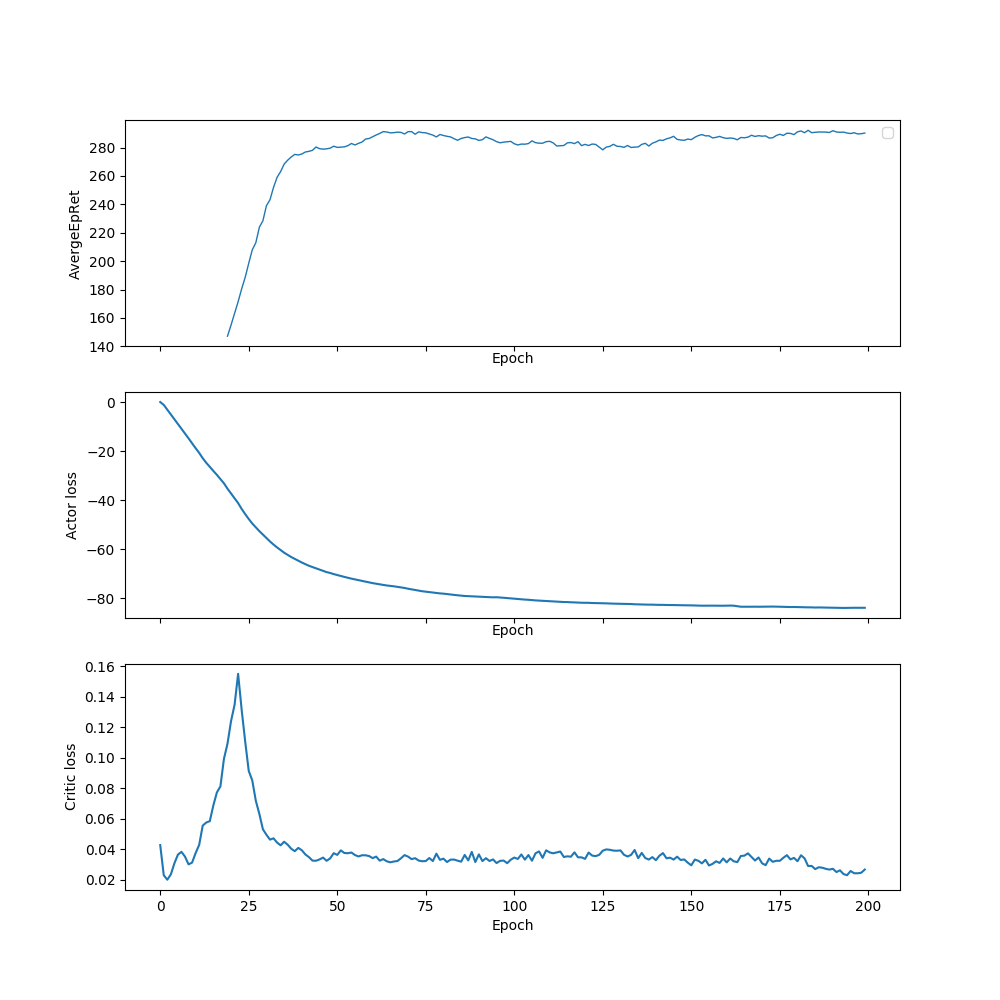

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


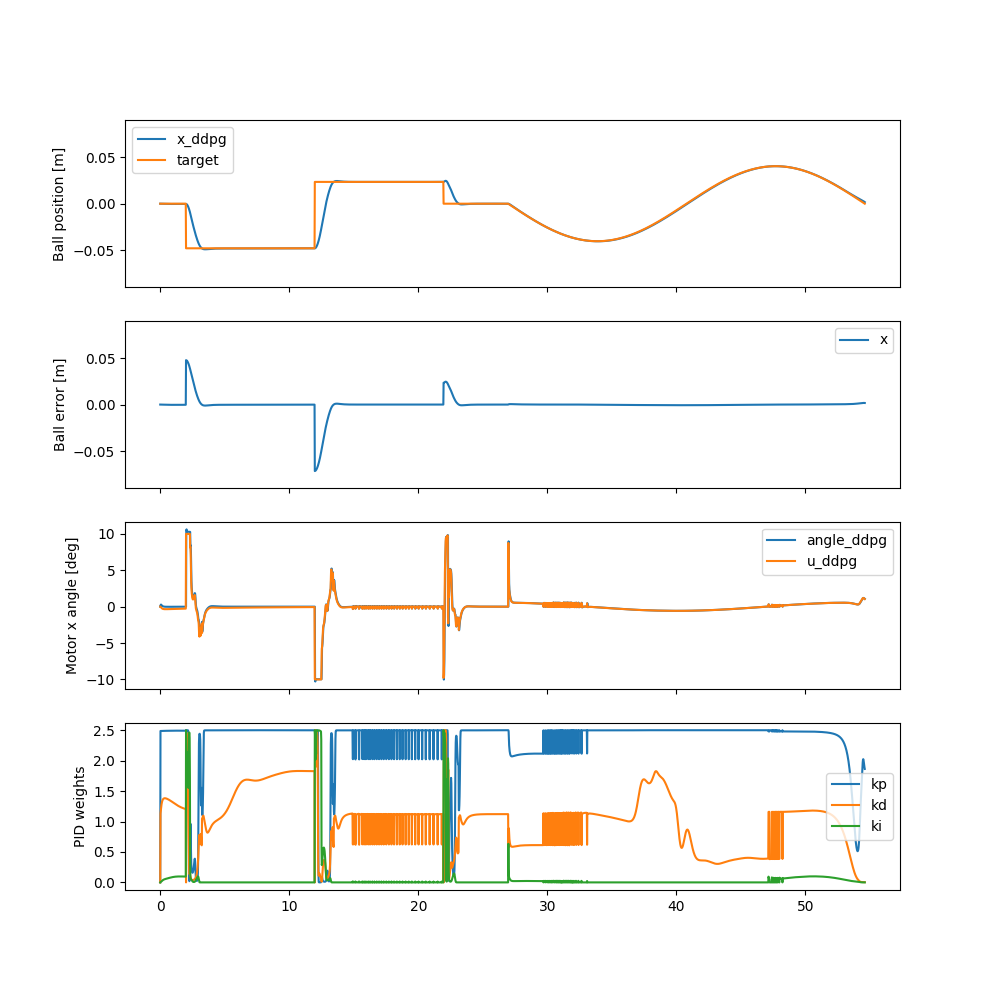

In [23]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,100]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100,100]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)